In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel



savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [ ]:
%load_ext autoreload
%autoreload 1

import os
import copy
import math
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
import torchmetrics.image.fid as fid
import lightning as L
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms as transforms
from pathlib import Path
from typing import Optional
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
from torchdyn.core import NeuralODE
from lightning.pytorch import Trainer, seed_everything
from torchvision import datasets
from torchvision.transforms import ToPILImage, Resize, InterpolationMode
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
from time import time
from PIL import Image

from jump_wtf.data.samplers import TimeGroupedSampler
from jump_wtf.models.unet_wrapper import UNetWrapperKoopman
from jump_wtf.models.autoencoder import Autoencoder_unet
from jump_wtf.models.model import Model
from jump_wtf.operators.generic import GenericOperator_state
from jump_wtf.data.datamodule import DynamicsDataModule
from jump_wtf.losses.koopman_loss import loss
from jump_wtf.utils.sampling import sample_efficient
from jump_wtf.utils.plot import sample_efficient_plot
from jump_wtf.utils.fid import FIDTrainCallback, FIDValCallback, compute_real_stats

In [2]:
"""From https://raw.githubusercontent.com/openai/guided-diffusion/main/guided_diffusion/unet.py."""
import math
from abc import abstractmethod

import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F



"""Helpers to train with 16-bit precision."""

import numpy as np
import torch as th
import torch.nn as nn
from torch._utils import _flatten_dense_tensors, _unflatten_dense_tensors

"""Logger copied from OpenAI baselines to avoid extra RL-based dependencies:

https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/logger.py
"""

import datetime
import json
import os
import os.path as osp
import shutil
import sys
import tempfile
import time
import warnings
from collections import defaultdict
from contextlib import contextmanager

DEBUG = 10
INFO = 20
WARN = 30
ERROR = 40

DISABLED = 50

"""Various utilities for neural networks."""

import math

import torch as th
import torch.nn as nn


# PyTorch 1.7 has SiLU, but we support PyTorch 1.5.
class SiLU(nn.Module):
    def forward(self, x):
        return x * th.sigmoid(x)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def conv_nd(dims, *args, **kwargs):
    """Create a 1D, 2D, or 3D convolution module."""
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """Create a linear module."""
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """Create a 1D, 2D, or 3D average pooling module."""
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def update_ema(target_params, source_params, rate=0.99):
    """Update target parameters to be closer to those of source parameters using an exponential
    moving average.

    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for targ, src in zip(target_params, source_params):
        targ.detach().mul_(rate).add_(src, alpha=1 - rate)




def zero_module(module, std=1e-3):
    """Initialize the parameters of a module with small Gaussian noise and return it."""
    for p in module.parameters():
        if p.dim() > 1:  # typically weights
            nn.init.normal_(p, mean=0.0, std=std)
        else:  # typically biases
            nn.init.zeros_(p)
    return module


def scale_module(module, scale):
    """Scale the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """Take the mean over all non-batch dimensions."""
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period)
        * th.arange(start=0, end=half, dtype=th.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def checkpoint(func, inputs, params, flag):
    """Evaluate a function without caching intermediate activations, allowing for reduced memory at
    the expense of extra compute in the backward pass.

    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(th.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with th.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with th.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = th.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads



class KVWriter:
    def writekvs(self, kvs):
        raise NotImplementedError


class SeqWriter:
    def writeseq(self, seq):
        raise NotImplementedError


class HumanOutputFormat(KVWriter, SeqWriter):
    def __init__(self, filename_or_file):
        if isinstance(filename_or_file, str):
            self.file = open(filename_or_file, "w")
            self.own_file = True
        else:
            assert hasattr(filename_or_file, "read"), (
                "expected file or str, got %s" % filename_or_file
            )
            self.file = filename_or_file
            self.own_file = False

    def writekvs(self, kvs):
        # Create strings for printing
        key2str = {}
        for key, val in sorted(kvs.items()):
            if hasattr(val, "__float__"):
                valstr = "%-8.3g" % val
            else:
                valstr = str(val)
            key2str[self._truncate(key)] = self._truncate(valstr)

        # Find max widths
        if len(key2str) == 0:
            print("WARNING: tried to write empty key-value dict")
            return
        else:
            keywidth = max(map(len, key2str.keys()))
            valwidth = max(map(len, key2str.values()))

        # Write out the data
        dashes = "-" * (keywidth + valwidth + 7)
        lines = [dashes]
        for key, val in sorted(key2str.items(), key=lambda kv: kv[0].lower()):
            lines.append(
                "| %s%s | %s%s |"
                % (key, " " * (keywidth - len(key)), val, " " * (valwidth - len(val)))
            )
        lines.append(dashes)
        self.file.write("\n".join(lines) + "\n")

        # Flush the output to the file
        self.file.flush()

    def _truncate(self, s):
        maxlen = 30
        return s[: maxlen - 3] + "..." if len(s) > maxlen else s

    def writeseq(self, seq):
        seq = list(seq)
        for i, elem in enumerate(seq):
            self.file.write(elem)
            if i < len(seq) - 1:  # add space unless this is the last one
                self.file.write(" ")
        self.file.write("\n")
        self.file.flush()

    def close(self):
        if self.own_file:
            self.file.close()


class JSONOutputFormat(KVWriter):
    def __init__(self, filename):
        self.file = open(filename, "w")

    def writekvs(self, kvs):
        for k, v in sorted(kvs.items()):
            if hasattr(v, "dtype"):
                kvs[k] = float(v)
        self.file.write(json.dumps(kvs) + "\n")
        self.file.flush()

    def close(self):
        self.file.close()


class CSVOutputFormat(KVWriter):
    def __init__(self, filename):
        self.file = open(filename, "w+t")
        self.keys = []
        self.sep = ","

    def writekvs(self, kvs):
        # Add our current row to the history
        extra_keys = list(kvs.keys() - self.keys)
        extra_keys.sort()
        if extra_keys:
            self.keys.extend(extra_keys)
            self.file.seek(0)
            lines = self.file.readlines()
            self.file.seek(0)
            for i, k in enumerate(self.keys):
                if i > 0:
                    self.file.write(",")
                self.file.write(k)
            self.file.write("\n")
            for line in lines[1:]:
                self.file.write(line[:-1])
                self.file.write(self.sep * len(extra_keys))
                self.file.write("\n")
        for i, k in enumerate(self.keys):
            if i > 0:
                self.file.write(",")
            v = kvs.get(k)
            if v is not None:
                self.file.write(str(v))
        self.file.write("\n")
        self.file.flush()

    def close(self):
        self.file.close()


class TensorBoardOutputFormat(KVWriter):
    """Dumps key/value pairs into TensorBoard's numeric format."""

    def __init__(self, dir):
        os.makedirs(dir, exist_ok=True)
        self.dir = dir
        self.step = 1
        prefix = "events"
        path = osp.join(osp.abspath(dir), prefix)
        import tensorflow as tf
        from tensorflow.core.util import event_pb2
        from tensorflow.python import pywrap_tensorflow
        from tensorflow.python.util import compat

        self.tf = tf
        self.event_pb2 = event_pb2
        self.pywrap_tensorflow = pywrap_tensorflow
        self.writer = pywrap_tensorflow.EventsWriter(compat.as_bytes(path))

    def writekvs(self, kvs):
        def summary_val(k, v):
            kwargs = {"tag": k, "simple_value": float(v)}
            return self.tf.Summary.Value(**kwargs)

        summary = self.tf.Summary(value=[summary_val(k, v) for k, v in kvs.items()])
        event = self.event_pb2.Event(wall_time=time.time(), summary=summary)
        event.step = self.step  # is there any reason why you'd want to specify the step?
        self.writer.WriteEvent(event)
        self.writer.Flush()
        self.step += 1

    def close(self):
        if self.writer:
            self.writer.Close()
            self.writer = None


def make_output_format(format, ev_dir, log_suffix=""):
    os.makedirs(ev_dir, exist_ok=True)
    if format == "stdout":
        return HumanOutputFormat(sys.stdout)
    elif format == "log":
        return HumanOutputFormat(osp.join(ev_dir, "log%s.txt" % log_suffix))
    elif format == "json":
        return JSONOutputFormat(osp.join(ev_dir, "progress%s.json" % log_suffix))
    elif format == "csv":
        return CSVOutputFormat(osp.join(ev_dir, "progress%s.csv" % log_suffix))
    elif format == "tensorboard":
        return TensorBoardOutputFormat(osp.join(ev_dir, "tb%s" % log_suffix))
    else:
        raise ValueError(f"Unknown format specified: {format}")


# ================================================================
# API
# ================================================================


def logkv(key, val):
    """Log a value of some diagnostic Call this once for each diagnostic quantity, each iteration
    If called many times, last value will be used."""
    get_current().logkv(key, val)


def logkv_mean(key, val):
    """The same as logkv(), but if called many times, values averaged."""
    get_current().logkv_mean(key, val)


def logkvs(d):
    """Log a dictionary of key-value pairs."""
    for k, v in d.items():
        logkv(k, v)


def dumpkvs():
    """Write all of the diagnostics from the current iteration."""
    return get_current().dumpkvs()


def getkvs():
    return get_current().name2val


def log(*args, level=INFO):
    """Write the sequence of args, with no separators, to the console and output files (if you've
    configured an output file)."""
    get_current().log(*args, level=level)


def debug(*args):
    log(*args, level=DEBUG)


def info(*args):
    log(*args, level=INFO)


def warn(*args):
    log(*args, level=WARN)


def error(*args):
    log(*args, level=ERROR)


def set_level(level):
    """Set logging threshold on current logger."""
    get_current().set_level(level)


def set_comm(comm):
    get_current().set_comm(comm)


def get_dir():
    """Get directory that log files are being written to.

    will be None if there is no output directory (i.e., if you didn't call start)
    """
    return get_current().get_dir()


record_tabular = logkv
dump_tabular = dumpkvs


@contextmanager
def profile_kv(scopename):
    logkey = "wait_" + scopename
    tstart = time.time()
    try:
        yield
    finally:
        get_current().name2val[logkey] += time.time() - tstart


def profile(n):
    """
    Usage:
    @profile("my_func")
    def my_func(): code
    """

    def decorator_with_name(func):
        def func_wrapper(*args, **kwargs):
            with profile_kv(n):
                return func(*args, **kwargs)

        return func_wrapper

    return decorator_with_name


# ================================================================
# Backend
# ================================================================


def get_current():
    if Logger.CURRENT is None:
        _configure_default_logger()

    return Logger.CURRENT


class Logger:
    DEFAULT = None  # A logger with no output files. (See right below class definition)
    # So that you can still log to the terminal without setting up any output files
    CURRENT = None  # Current logger being used by the free functions above

    def __init__(self, dir, output_formats, comm=None):
        self.name2val = defaultdict(float)  # values this iteration
        self.name2cnt = defaultdict(int)
        self.level = INFO
        self.dir = dir
        self.output_formats = output_formats
        self.comm = comm

    # Logging API, forwarded
    # ----------------------------------------
    def logkv(self, key, val):
        self.name2val[key] = val

    def logkv_mean(self, key, val):
        oldval, cnt = self.name2val[key], self.name2cnt[key]
        self.name2val[key] = oldval * cnt / (cnt + 1) + val / (cnt + 1)
        self.name2cnt[key] = cnt + 1

    def dumpkvs(self):
        if self.comm is None:
            d = self.name2val
        else:
            d = mpi_weighted_mean(
                self.comm,
                {name: (val, self.name2cnt.get(name, 1)) for (name, val) in self.name2val.items()},
            )
            if self.comm.rank != 0:
                d["dummy"] = 1  # so we don't get a warning about empty dict
        out = d.copy()  # Return the dict for unit testing purposes
        for fmt in self.output_formats:
            if isinstance(fmt, KVWriter):
                fmt.writekvs(d)
        self.name2val.clear()
        self.name2cnt.clear()
        return out

    def log(self, *args, level=INFO):
        if self.level <= level:
            self._do_log(args)

    # Configuration
    # ----------------------------------------
    def set_level(self, level):
        self.level = level

    def set_comm(self, comm):
        self.comm = comm

    def get_dir(self):
        return self.dir

    def close(self):
        for fmt in self.output_formats:
            fmt.close()

    # Misc
    # ----------------------------------------
    def _do_log(self, args):
        for fmt in self.output_formats:
            if isinstance(fmt, SeqWriter):
                fmt.writeseq(map(str, args))


def get_rank_without_mpi_import():
    # check environment variables here instead of importing mpi4py
    # to avoid calling MPI_Init() when this module is imported
    for varname in ["PMI_RANK", "OMPI_COMM_WORLD_RANK"]:
        if varname in os.environ:
            return int(os.environ[varname])
    return 0


def mpi_weighted_mean(comm, local_name2valcount):
    """
    Copied from: https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/common/mpi_util.py#L110
    Perform a weighted average over dicts that are each on a different node
    Input: local_name2valcount: dict mapping key -> (value, count)
    Returns: key -> mean
    """
    all_name2valcount = comm.gather(local_name2valcount)
    if comm.rank == 0:
        name2sum = defaultdict(float)
        name2count = defaultdict(float)
        for n2vc in all_name2valcount:
            for name, (val, count) in n2vc.items():
                try:
                    val = float(val)
                except ValueError:
                    if comm.rank == 0:
                        warnings.warn(f"WARNING: tried to compute mean on non-float {name}={val}")
                else:
                    name2sum[name] += val * count
                    name2count[name] += count
        return {name: name2sum[name] / name2count[name] for name in name2sum}
    else:
        return {}


def configure(dir=None, format_strs=None, comm=None, log_suffix=""):
    """If comm is provided, average all numerical stats across that comm."""
    if dir is None:
        dir = os.getenv("OPENAI_LOGDIR")
    if dir is None:
        dir = osp.join(
            tempfile.gettempdir(),
            datetime.datetime.now().strftime("openai-%Y-%m-%d-%H-%M-%S-%f"),
        )
    assert isinstance(dir, str)
    dir = os.path.expanduser(dir)
    os.makedirs(os.path.expanduser(dir), exist_ok=True)

    rank = get_rank_without_mpi_import()
    if rank > 0:
        log_suffix = log_suffix + "-rank%03i" % rank

    if format_strs is None:
        if rank == 0:
            format_strs = os.getenv("OPENAI_LOG_FORMAT", "stdout,log,csv").split(",")
        else:
            format_strs = os.getenv("OPENAI_LOG_FORMAT_MPI", "log").split(",")
    format_strs = filter(None, format_strs)
    output_formats = [make_output_format(f, dir, log_suffix) for f in format_strs]

    Logger.CURRENT = Logger(dir=dir, output_formats=output_formats, comm=comm)
    if output_formats:
        log("Logging to %s" % dir)


def _configure_default_logger():
    configure()
    Logger.DEFAULT = Logger.CURRENT


def reset():
    if Logger.CURRENT is not Logger.DEFAULT:
        Logger.CURRENT.close()
        Logger.CURRENT = Logger.DEFAULT
        log("Reset logger")


@contextmanager
def scoped_configure(dir=None, format_strs=None, comm=None):
    prevlogger = Logger.CURRENT
    configure(dir=dir, format_strs=format_strs, comm=comm)
    try:
        yield
    finally:
        Logger.CURRENT.close()
        Logger.CURRENT = prevlogger


INITIAL_LOG_LOSS_SCALE = 20.0


def convert_module_to_f16(l):
    """Convert primitive modules to float16."""
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half()
        if l.bias is not None:
            l.bias.data = l.bias.data.half()


def convert_module_to_f32(l):
    """Convert primitive modules to float32, undoing convert_module_to_f16()."""
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.float()
        if l.bias is not None:
            l.bias.data = l.bias.data.float()


def make_master_params(param_groups_and_shapes):
    """Copy model parameters into a (differently-shaped) list of full-precision parameters."""
    master_params = []
    for param_group, shape in param_groups_and_shapes:
        master_param = nn.Parameter(
            _flatten_dense_tensors([param.detach().float() for (_, param) in param_group]).view(
                shape
            )
        )
        master_param.requires_grad = True
        master_params.append(master_param)
    return master_params


def model_grads_to_master_grads(param_groups_and_shapes, master_params):
    """Copy the gradients from the model parameters into the master parameters from
    make_master_params()."""
    for master_param, (param_group, shape) in zip(master_params, param_groups_and_shapes):
        master_param.grad = _flatten_dense_tensors(
            [param_grad_or_zeros(param) for (_, param) in param_group]
        ).view(shape)


def master_params_to_model_params(param_groups_and_shapes, master_params):
    """Copy the master parameter data back into the model parameters."""
    # Without copying to a list, if a generator is passed, this will
    # silently not copy any parameters.
    for master_param, (param_group, _) in zip(master_params, param_groups_and_shapes):
        for (_, param), unflat_master_param in zip(
            param_group, unflatten_master_params(param_group, master_param.view(-1))
        ):
            param.detach().copy_(unflat_master_param)


def unflatten_master_params(param_group, master_param):
    return _unflatten_dense_tensors(master_param, [param for (_, param) in param_group])


def get_param_groups_and_shapes(named_model_params):
    named_model_params = list(named_model_params)
    scalar_vector_named_params = (
        [(n, p) for (n, p) in named_model_params if p.ndim <= 1],
        (-1),
    )
    matrix_named_params = (
        [(n, p) for (n, p) in named_model_params if p.ndim > 1],
        (1, -1),
    )
    return [scalar_vector_named_params, matrix_named_params]


def master_params_to_state_dict(model, param_groups_and_shapes, master_params, use_fp16):
    if use_fp16:
        state_dict = model.state_dict()
        for master_param, (param_group, _) in zip(master_params, param_groups_and_shapes):
            for (name, _), unflat_master_param in zip(
                param_group, unflatten_master_params(param_group, master_param.view(-1))
            ):
                assert name in state_dict
                state_dict[name] = unflat_master_param
    else:
        state_dict = model.state_dict()
        for i, (name, _value) in enumerate(model.named_parameters()):
            assert name in state_dict
            state_dict[name] = master_params[i]
    return state_dict


def state_dict_to_master_params(model, state_dict, use_fp16):
    if use_fp16:
        named_model_params = [(name, state_dict[name]) for name, _ in model.named_parameters()]
        param_groups_and_shapes = get_param_groups_and_shapes(named_model_params)
        master_params = make_master_params(param_groups_and_shapes)
    else:
        master_params = [state_dict[name] for name, _ in model.named_parameters()]
    return master_params


def zero_master_grads(master_params):
    for param in master_params:
        param.grad = None


def zero_grad(model_params):
    for param in model_params:
        # Taken from https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer.add_param_group
        if param.grad is not None:
            param.grad.detach_()
            param.grad.zero_()


def param_grad_or_zeros(param):
    if param.grad is not None:
        return param.grad.data.detach()
    else:
        return th.zeros_like(param)


class MixedPrecisionTrainer:
    def __init__(
        self,
        *,
        model,
        use_fp16=False,
        fp16_scale_growth=1e-3,
        initial_lg_loss_scale=INITIAL_LOG_LOSS_SCALE,
    ):
        self.model = model
        self.use_fp16 = use_fp16
        self.fp16_scale_growth = fp16_scale_growth

        self.model_params = list(self.model.parameters())
        self.master_params = self.model_params
        self.param_groups_and_shapes = None
        self.lg_loss_scale = initial_lg_loss_scale

        if self.use_fp16:
            self.param_groups_and_shapes = get_param_groups_and_shapes(
                self.model.named_parameters()
            )
            self.master_params = make_master_params(self.param_groups_and_shapes)
            self.model.convert_to_fp16()

    def zero_grad(self):
        zero_grad(self.model_params)

    def backward(self, loss: th.Tensor):
        if self.use_fp16:
            loss_scale = 2**self.lg_loss_scale
            (loss * loss_scale).backward()
        else:
            loss.backward()

    def optimize(self, opt: th.optim.Optimizer):
        if self.use_fp16:
            return self._optimize_fp16(opt)
        else:
            return self._optimize_normal(opt)

    def _optimize_fp16(self, opt: th.optim.Optimizer):
        logger.logkv_mean("lg_loss_scale", self.lg_loss_scale)
        model_grads_to_master_grads(self.param_groups_and_shapes, self.master_params)
        grad_norm, param_norm = self._compute_norms(grad_scale=2**self.lg_loss_scale)
        if check_overflow(grad_norm):
            self.lg_loss_scale -= 1
            logger.log(f"Found NaN, decreased lg_loss_scale to {self.lg_loss_scale}")
            zero_master_grads(self.master_params)
            return False

        logger.logkv_mean("grad_norm", grad_norm)
        logger.logkv_mean("param_norm", param_norm)

        for p in self.master_params:
            p.grad.mul_(1.0 / (2**self.lg_loss_scale))
        opt.step()
        zero_master_grads(self.master_params)
        master_params_to_model_params(self.param_groups_and_shapes, self.master_params)
        self.lg_loss_scale += self.fp16_scale_growth
        return True

    def _optimize_normal(self, opt: th.optim.Optimizer):
        grad_norm, param_norm = self._compute_norms()
        logger.logkv_mean("grad_norm", grad_norm)
        logger.logkv_mean("param_norm", param_norm)
        opt.step()
        return True

    def _compute_norms(self, grad_scale=1.0):
        grad_norm = 0.0
        param_norm = 0.0
        for p in self.master_params:
            with th.no_grad():
                param_norm += th.norm(p, p=2, dtype=th.float32).item() ** 2
                if p.grad is not None:
                    grad_norm += th.norm(p.grad, p=2, dtype=th.float32).item() ** 2
        return np.sqrt(grad_norm) / grad_scale, np.sqrt(param_norm)

    def master_params_to_state_dict(self, master_params):
        return master_params_to_state_dict(
            self.model, self.param_groups_and_shapes, master_params, self.use_fp16
        )

    def state_dict_to_master_params(self, state_dict):
        return state_dict_to_master_params(self.model, state_dict, self.use_fp16)


def check_overflow(value):
    return (value == float("inf")) or (value == -float("inf")) or (value != value)


class AttentionPool2d(nn.Module):
    """Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py."""

    def __init__(
        self,
        spacial_dim: int,
        embed_dim: int,
        num_heads_channels: int,
        output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(
            th.randn(embed_dim, spacial_dim**2 + 1) / embed_dim**0.5
        )
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """Any module where forward() takes timestep embeddings as a second argument."""

    @abstractmethod
    def forward(self, x, emb):
        """Apply the module to `x` given `emb` timestep embeddings."""


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """A sequential module that passes timestep embeddings to the children that support it as an
    extra input."""

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """An upsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then upsampling occurs in the
        inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """A downsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then downsampling occurs in the
        inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(dims, self.channels, self.out_channels, 3, stride=stride, padding=1)
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """A residual block that can optionally change the number of channels.

    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial convolution instead of a
        smaller 1x1 convolution to change the channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 3, padding=1)
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """Apply the block to a Tensor, conditioned on a timestep embedding.

        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(self._forward, (x, emb), self.parameters(), self.use_checkpoint)

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """An attention block that allows spatial positions to attend to each other.

    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), self.use_checkpoint)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """A counter for the `thop` package to count the operations in an attention operation.

    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """A module which performs QKV attention.

    Matches legacy QKVAttention + input/output heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """Apply QKV attention.

        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """A module which performs QKV attention and splits in a different order."""

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """Apply QKV attention.

        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class EncoderUNetModel(nn.Module):
    """The half UNet model with attention and timestep embedding.

    For usage, see UNet.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch
        self.pool = pool
        if pool == "adaptive":
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                nn.AdaptiveAvgPool2d((1, 1)),
                zero_module(conv_nd(dims, ch, out_channels, 1)),
                nn.Flatten(),
            )
        elif pool == "attention":
            assert num_head_channels != -1
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                AttentionPool2d((image_size // ds), ch, num_head_channels, out_channels),
            )
        elif pool == "spatial":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                nn.ReLU(),
                nn.Linear(2048, self.out_channels),
            )
        elif pool == "spatial_v2":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                normalization(2048),
                nn.SiLU(),
                nn.Linear(2048, self.out_channels),
            )
        else:
            raise NotImplementedError(f"Unexpected {pool} pooling")

    def convert_to_fp16(self):
        """Convert the torso of the model to float16."""
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """Convert the torso of the model to float32."""
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)

    def forward(self, inputs):
        """Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x K] Tensor of outputs.
        """
        x = inputs[:,1:].reshape((-1, 1, 28, 28))
        timesteps = inputs[:,0]
        
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            if self.pool.startswith("spatial"):
                results.append(h.type(x.dtype).mean(dim=(2, 3)))
        h = self.middle_block(h, emb)
        if self.pool.startswith("spatial"):
            results.append(h.type(x.dtype).mean(dim=(2, 3)))
            h = th.cat(results, axis=-1)
            return self.out(h)
        else:
            h = h.type(x.dtype)
            return torch.hstack((inputs,self.out(h)))




NUM_CLASSES = 1000


class UNetModelKoopman(nn.Module):
    """The full UNet model with attention and timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """Convert the torso of the model to float16."""
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """Convert the torso of the model to float32."""
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, t, x, y=None):
        """Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        timesteps = t
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        out = self.out(h)
        #reshape for better koopman
        out = out.view(out.shape[0],-1)
        out = torch.hstack((torch.ones(out.shape[0], 1, device=out.device), out))  
        return out
    
class UNetModelWrapperKoopman(UNetModelKoopman):
    def __init__(
        self,
        dim,
        num_channels,
        num_res_blocks,
        channel_mult=None,
        learn_sigma=False,
        class_cond=False,
        num_classes=NUM_CLASSES,
        use_checkpoint=False,
        attention_resolutions="16",
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        dropout=0,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False,
    ):
        """Dim (tuple): (C, H, W)"""
        image_size = dim[-1]
        if channel_mult is None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            elif image_size == 32:
                channel_mult = (1, 2, 2, 2)
            elif image_size == 28:
                channel_mult = (1, 2, 2)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        else:
            channel_mult = list(channel_mult)

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        return super().__init__(
            image_size=image_size,
            in_channels=dim[0],
            model_channels=num_channels,
            out_channels=(dim[0] if not learn_sigma else dim[0] * 2),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(num_classes if class_cond else None),
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order,
        )

    def forward(self, t, x, y=None, *args, **kwargs):
        return super().forward(t, x, y=y)

class EncoderUNetModelWrapper(EncoderUNetModel):
    def __init__(
        self,
        dim,
        num_channels,
        num_res_blocks,
        channel_mult=None,
        dropout=0,
        attention_resolutions="16",
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
    ):
        """Dim (tuple): (C, H, W)"""
        image_size = dim[-1]

        if channel_mult is None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            elif image_size == 32:
                channel_mult = (1, 2, 2, 2)
            elif image_size == 28:
                channel_mult = (1, 2, 2)
            else:
                raise ValueError(f"unsupported image size: {image_size}")

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        super().__init__(
            image_size=image_size,
            in_channels=dim[0],
            model_channels=num_channels,
            out_channels=num_channels,
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            conv_resample=True,
            dims=2,
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order,
            pool=pool,
        )

    def forward(self, inputs):
        return super().forward(inputs)

In [3]:
batch_size = 128

# Full MNIST dataset: (why not?)

In [4]:
#full mnist reduce to 10 000 random samples 
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)



# Randomly select 10,000 indices
#total_samples = 10000
#random_indices = torch.randperm(len(full_trainset))[:total_samples]
#subset_dataset = Subset(trainset, random_indices)

# DataLoader
train_loader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)


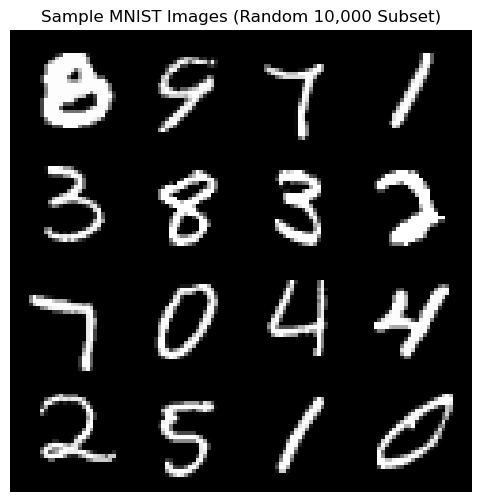

In [5]:
#Let's plot some to make sure
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalize images: [-1, 1] → [0, 1]
images = images * 0.5 + 0.5

# Create a grid of the first 16 images
grid_img = vutils.make_grid(images[:16], nrow=4, padding=2)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Sample MNIST Images (Random 10,000 Subset)")
plt.show()


Let's learn the flow via CFM:

In [10]:
#################################
#            OT-CFM
#################################


n_epochs = 20

sigma = 0.0

model = UNetModel(
        dim=(1, 28, 28), 
        num_channels=64, 
        num_res_blocks=2,
        num_heads=4,
    ).to(device)

# model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device) #for MNIST
#model = UNetModel(dim=(1, 32, 32), num_channels=32, num_res_blocks=1).to(device) #for CIFAR-10
optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [7]:
#torch.save(model.state_dict(), "/home/turan/koopman/cfm_model/unet_model_mnist.pth")

In [ ]:
model.load_state_dict(torch.load("assets/unet_dynamics/toronto_face_toronto_face_otcfm_step-30000.pt"))
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

/tmp/ipykernel_2948497/1004317380.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("assets/unet_dynamics/toronto_face_toronto_face_otcfm_

In [12]:
dynamics = UNetModelWrapperKoopman(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to("cpu")

dynamics = UNetModel(
        dim=(1, 28, 28), 
        num_channels=64, 
        num_res_blocks=2,
        num_heads=4,
    ).to(device)


dynamics.load_state_dict(torch.load("assets/unet_dynamics/toronto_face_toronto_face_otcfm_step-30000.pt"))

/tmp/ipykernel_2948497/4231259669.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dynamics.load_state_dict(torch.load("assets/unet_dynamics/toronto_face_toronto_face_ot

<All keys matched successfully>

In [13]:
for p in dynamics.parameters():
    p.requires_grad = False

In [14]:
from time import time

Sampling time: 5.850276231765747


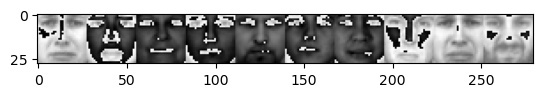

In [15]:
#Check that the learned flow generates ok samples
with torch.no_grad():
    top = time()
    traj = node.trajectory(
        torch.randn(10, 1, 28, 28, device=device),
        t_span=torch.linspace(0, 1, 100, device=device),
    )
    print(f'Sampling time: {(time()-top)}')
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)


In [16]:
len(trainset)

60000

# Prepare 2000 trajectories out of all 60 000 digits in dataset.

In [ ]:

# #for the dataset
# with torch.no_grad():
#     top = time()
#     traj = node.trajectory(
#         torch.randn(200, 1, 28, 28, device=device),
#         t_span=torch.linspace(0, 1, 100, device=device),
#     )
#     print(f'Sampling time: {(time()-top)}')
# grid = make_grid(
#     traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
# )
# img = ToPILImage()(grid)
# plt.imshow(img)



KeyboardInterrupt: 

In [17]:
traj = traj.to("cpu")

In [ ]:
#torch.save(traj, "/home/turan/conditional-flow-matching/examples/images/traj.pth")

In [18]:
traj = torch.load("assets/dynamics_datasets/intermediate_traj/toronto_face_toronto_face_otcfm_step-30000_traj_ema_100.pth")

/tmp/ipykernel_2948497/4271432374.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj = torch.load("assets/dynamics_datasets/intermediate_traj/toronto_face_toronto_face

In [19]:
#traj = traj[:,:200,:,:,:]

In [20]:
traj.shape

torch.Size([100, 20000, 1, 28, 28])

# Koopman

In [21]:
import torch
from lightning.pytorch import Trainer, seed_everything
import torch.nn as nn
import lightning as L
import torch.autograd as autograd


In [22]:
traj.shape

torch.Size([100, 20000, 1, 28, 28])

In [23]:
class RandomTimeSampler(torch.utils.data.Sampler):
            def __init__(self, time_steps=100, group_size=2000):
                self.time_steps = time_steps
                self.group_size = group_size
                self.total_size = time_steps * group_size
            def __iter__(self):
                # Create a list of all possible indices
                all_indices = list(range(self.total_size))
                # Randomly shuffle the indices to sample random timesteps
                indices = []
                time_indices = list(range(self.time_steps))
                np.random.shuffle(time_indices)  # Shuffle the time indices
                for t in time_indices:
                    # Get the indices for this timestep
                    start_idx = t * self.group_size
                    end_idx = start_idx + self.group_size
                    # Get all indices for this timestep
                    time_slice_indices = list(range(start_idx, end_idx))
                    np.random.shuffle(time_slice_indices)  # Shuffle within the time slice
                    # Add to our list of indices
                    indices.extend(time_slice_indices)
                return iter(indices)
            def __len__(self):
                return self.total_size

In [24]:
#Allows more efficient training by taking a group of points that are at the same timestep. That way I can compute one evolution operator to evolve it to target
from torch.utils.data import Sampler

class TimeGroupedSampler(Sampler):
    def __init__(self, time_steps, group_size):
        self.time_steps = time_steps  # e.g., 100 time slices
        self.group_size = group_size  # e.g., 2000 samples per t
        self.indices = self._build_indices()

    def _build_indices(self):
        all_indices = []
        for i in reversed(range(self.time_steps)):  # reverse time
            start = i * self.group_size
            end = (i + 1) * self.group_size
            indices = list(range(start, end))
            np.random.shuffle(indices)
            all_indices.extend(indices)
        return all_indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [25]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class DynamicsDataModule(L.LightningDataModule):
    def __init__(self, batch_size=32, num_iter=100, dynamics=None, traj=None):
        super().__init__()
        self.batch_size = batch_size
        self.num_iter = num_iter
        self.t = torch.linspace(0, 1, self.num_iter, dtype=torch.float32)
        self.dynamics = dynamics.to(torch.float32).to(device)
        self.traj = [t.to(torch.float32).to(device) for t in traj]

    def setup(self, stage=None):
        if not hasattr(self, "train_dataset"):
            matrix_x0 = []
            matrix_system_derivative_data = []
            matrix_targets = []
            matrix_delta_t = []

            for i in range(len(self.traj)):
                t_val = self.t[i]

                x1 = self.traj[-1].to(torch.float32).to(device)  # final target
                x = self.traj[i].to(torch.float32).to(device)

                t = torch.ones((x.shape[0], 1), dtype=torch.float32, device=device) * t_val
                delta_t = 1.0 - t  # time to target

                with torch.no_grad():
                    dx = self.dynamics(t, x)  # vector field

                matrix_system_derivative_data.append(dx)

                t_one = torch.ones((x.shape[0], 1), dtype=torch.float32, device=device)
                x1 = x1.reshape((len(x1), -1))
                targets = torch.hstack((t_one, x1))

                matrix_targets.append(targets)
                matrix_delta_t.append(delta_t)

                x = x.reshape((len(x), -1))
                inputs = torch.hstack((t, x))
                matrix_x0.append(inputs)

            # Stack all collected data
            matrix_targets = torch.vstack(matrix_targets)
            matrix_delta_t = torch.vstack(matrix_delta_t)
            matrix_x0 = torch.vstack(matrix_x0)
            matrix_system_derivative_data = torch.vstack(matrix_system_derivative_data)

            # Print shapes for sanity check
            print("matrix_x0:", matrix_x0.shape)
            print("matrix_system_derivative_data:", matrix_system_derivative_data.shape)
            print("matrix_targets:", matrix_targets.shape)
            print("matrix_delta_t:", matrix_delta_t.shape)

            # Store as float64 CPU tensors
            self.train_dataset = TensorDataset(
                matrix_x0.cpu(), 
                matrix_system_derivative_data.cpu(), 
                matrix_targets.cpu(), 
                matrix_delta_t.cpu()
            )

    def train_dataloader(self):
        sampler = RandomTimeSampler(time_steps=100, group_size=2500)
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=sampler,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
            persistent_workers=False
        )

    def test_dataloader(self):
        return None

    def predict_dataloader(self):
        return None


In [26]:
class DynamicsDataModule(L.LightningDataModule):
    def __init__(self, batch_size=32, num_iter=100, dynamics=dynamics, traj=traj, chunk_size=200):
        super().__init__()
        self.batch_size = batch_size
        self.num_iter = num_iter
        self.chunk_size = chunk_size
        self.t = np.linspace(0, 1, self.num_iter)
        self.dynamics = dynamics.to(device)
        self.traj = traj
    def on_exception(self, exception: BaseException):
        pass  # required by older Lightning versions
    
    def setup(self, stage=None):
        if not hasattr(self, "train_dataset"):  # Ensure dataset is created only once
            matrix_x0 = []
            matrix_system_derivative_data = []
            matrix_targets = []
            matrix_delta_t = []

            for i in range(len(self.traj)):
                t_val = self.t[i]
                #if i == 25:
                #    print(self.t)
                #    print(self.t[i])
                x_full = self.traj[i].to(device)
                x1_full = self.traj[-1].to("cpu")
                num_samples = x_full.shape[0]
                for start in range(0, num_samples, self.chunk_size):
                    end = min(start + self.chunk_size, num_samples)

                    x = x_full[start:end]
                    x1 = x1_full[start:end]

                    t = torch.ones((x.shape[0], 1), device=x.device) * t_val
                    
                    delta_t = 1 - t

                    with torch.no_grad():
                        dx = self.dynamics(t, x)

                    t_one = torch.ones((x.shape[0], 1), device="cpu")
                    x1 = x1.reshape((x1.shape[0], -1))
                    #print(t_one.device)
                    #print(x1.device)
                    targets = torch.hstack((t_one, x1))

                    x = x.reshape((x.shape[0], -1))
                    #inputs = torch.hstack((normalize_time(t, 0.75, 1), x))
                    inputs = torch.hstack((t, x))

                    matrix_system_derivative_data.append(dx)
                    matrix_targets.append(targets)
                    matrix_delta_t.append(delta_t)
                    matrix_x0.append(inputs)

            print(len(matrix_targets))
            matrix_targets = torch.vstack(matrix_targets)
            matrix_delta_t = torch.vstack(matrix_delta_t)
            matrix_x0 = torch.vstack(matrix_x0)
            matrix_system_derivative_data = torch.vstack(matrix_system_derivative_data)

            print("matrix_x0:", matrix_x0.shape)
            print("matrix_system_derivative_data:", matrix_system_derivative_data.shape)
            print("matrix_targets:", matrix_targets.shape)
            print("matrix_delta_t:", matrix_delta_t.shape)

            self.train_dataset = TensorDataset(
                matrix_x0.float().to("cpu"),
                matrix_system_derivative_data.float().to("cpu"),
                matrix_targets.float().to("cpu"),
                matrix_delta_t.float().to("cpu")
            )

    def train_dataloader(self):
        sampler = TimeGroupedSampler(time_steps=100, group_size=2500)
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
           sampler=sampler,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
            persistent_workers=False
        )

    def test_dataloader(self):
        pass

    def predict_dataloader(self):
        pass

# Modified the loss term:

Now takes in more inputs: targets, time_to_target which come from the modified datamodule.

In [27]:
import copy
import torch
import math
from torch.optim.lr_scheduler import _LRScheduler

In [28]:
# Implement the loss function here
# See the training process below to identify the different components of the loss
def loss(model, tensor2d_x: torch.Tensor,
         tensor2d_x_next: torch.Tensor,
         tensor2d_decoded_x: torch.Tensor,
         tensor2d_observable: torch.Tensor,
         tensor2d_lie_observable_next: torch.Tensor,
         tensor2d_predict_x_next: torch.Tensor,
         tensor2d_jvp: torch.Tensor, targets, 
         time_to_target, loss_function, vae_loss_bool=False,
         
         decode_predict_bool=False, 
         koop_reg_bool=False, 
         energy_bool = False, 
         potential_function = None, 
         delta_t=0.01, 
         period=10, 
         multistep_loss_bool=False, time_bool=False, n_iter=100, cfm_model=None):
    
    lie_operator = model.koopman 
    autoencoder = model.autoencoder 
    loss = loss_function

    output_dim = model.koopman.operator_dim
    
    #print(time_to_target)
    evolution_operators = get_koop_continuous_batch(model, output_dim, time_to_target.to(device)[0])
    #print(evolution_operators.shape)
    encoded_points = model.autoencoder.encoder(tensor2d_x)
    #print(encoded_points.shape)
    predicted_samples_phase = (encoded_points@evolution_operators).squeeze(0)
    #print(predicted_samples.shape)
    predicted_samples = model.autoencoder.decoder(predicted_samples_phase)
    sample_loss = loss(targets, predicted_samples)
    sample_loss_phase = loss(predicted_samples_phase, model.autoencoder.encoder(targets))



    if not(multistep_loss_bool): #model.current_epoch<100:
        multistep = 0 
    
    else: 
      if multistep_loss_bool==True:
        t_max = 1  # Number of time steps integration
        n_initial_conditions = len(tensor2d_x)  # Number of initial conditions
        dim_system = 2
        array_t = np.linspace(0, t_max, n_iter)
        solutions = np.zeros((tensor2d_x.shape[0], dim_system, n_iter))

      
        for i in tqdm(range(tensor2d_x.shape[0])):
          if time_bool:
            if cfm_model != None:
            
              result = solve_ivp(lambda t, x: model.dynamics(cfm_model, t,x), [0, t_max], tensor2d_x[:,:2].cpu().numpy()[i], method="RK45", t_eval=array_t)
            else:
            
              result = solve_ivp(lambda t, x: model.dynamics(t,x), [0, t_max], tensor2d_x[:,:2].cpu().numpy()[i], method="RK45", t_eval=array_t)
          else:
          
            result = solve_ivp(lambda _t, x: model.dynamics(x), [0, t_max], tensor2d_x.cpu().numpy()[i], method="RK45", t_eval=array_t)
          solutions[i,:] = result.y
        #solutions = torch.Tensor(solutions).to("cuda")

        multistep = multistep_loss(model, tensor2d_x, solutions, period, time_bool)
        #reconstruction loss
    
    
    for p in lie_operator.parameters():
      p.requires_grad = True
    #for p in lie_operator.parameters():
    #  p.requires_grad = False
    
    for p in autoencoder.encoder.parameters():
      p.requires_grad = True
    
    #for p in autoencoder.encoder.parameters():
    #  p.requires_grad = False
    
    reconstructed = loss(tensor2d_decoded_x,tensor2d_x)
    
    
    #the decoder doesn't intervene here

    for p in autoencoder.decoder.parameters():
      p.requires_grad = False

    grad_phase = loss(tensor2d_lie_observable_next, tensor2d_jvp)

    #for p in autoencoder.decoder.parameters():
    #  p.requires_grad = True
    
    #predict only need the decoder so fix the encoder 

    #for p in autoencoder.encoder.parameters():
    #  p.requires_grad = False

    decode_predict = loss(tensor2d_predict_x_next, tensor2d_x_next)

    #for p in autoencoder.encoder.parameters():
    #  p.requires_grad = True

    for p in autoencoder.decoder.parameters():
      p.requires_grad = False
    for p in lie_operator.parameters():
      p.requires_grad = False

    if vae_loss_bool:
      vae_loss = torch.abs(torch.mean(tensor2d_observable)) + torch.abs(torch.std(tensor2d_observable)-1)
    else: 
      vae_loss = 0 

    for p in autoencoder.decoder.parameters():
      p.requires_grad = True
    for p in lie_operator.parameters():
      p.requires_grad = True

    #for p in autoencoder.decoder.parameters():
    #  p.requires_grad = False
    
    #for p in autoencoder.encoder.parameters():
    #  p.requires_grad = False
    
    
    lie_module = model.koopman.operator
    
    if koop_reg_bool:
      koopman = torch.matrix_exp(lie_module*delta_t)
      koopman_reg = torch.sum(torch.abs(torch.matmul(torch.conj(koopman.T), koopman)-torch.eye(koopman.shape[0]).to(device)))
    else:
      koopman_reg = 0 

    #for p in autoencoder.decoder.parameters():
    #  p.requires_grad = True
    
    #for p in autoencoder.encoder.parameters():
    #  p.requires_grad = True

    lie_linear = lie_module[:,:785].detach()
    lie_linear.requires_grad = False
    
    
    if not(decode_predict_bool):
      decode_predict = 0 
    

    output_dim = lie_operator.operator_dim
    
    #linear_collapse = lie_operator.operator[:,:785].norm()
  
    if energy_bool:
      energy_loss_term = energy_loss(model, tensor2d_x, 0.01, output_dim, potential_function)
      total_loss = 0.2*reconstructed + 0.6*grad_phase + 0.2*decode_predict + 0.1*vae_loss + 0.1*koopman_reg + 0.6*energy_loss_term + 0.01*multistep
    else:
      energy_loss_term = 0
      total_loss = 0.2*reconstructed + grad_phase + 0.1*vae_loss + 0.1*koopman_reg + 0.01*multistep + 0.1*sample_loss_phase

    #for p in lie_operator.parameters():
    #  p.requires_grad = True
    
    #for p in autoencoder.encoder.parameters():
    #  p.requires_grad = True
      
  
    # TODO: Implement loss
    return total_loss, 0.2*reconstructed ,grad_phase, 0.2*decode_predict, 0.1*vae_loss, 0.1*koopman_reg, 0.01*energy_loss_term, 0.01*multistep, 0, 0.1*sample_loss_phase


In [29]:
class Model(L.LightningModule):
    def __init__(self, dynamics, autoencoder, koopman, 
                 loss_function, autoencoder_lr, lie_lr, 
                 lr_scheduler, decode_predict_bool=True, 
                 vae_loss_bool=False, koop_reg_bool=False, energy_bool=False, 
                 potential_function=None,  
                 gamma=None, delta_t = 0.01, multistep=False, period=10, time_bool=False, plot_every=50, num_iter=100, cfm_model=None, warmup_step=1000):
        super().__init__()
        self.save_hyperparameters(ignore=["autoencoder", "koopman", "loss_function", "dynamics", "potential_function", "cfm_model"])

        #self.save_hyperparameters()  # This helps with checkpointing
        self.autoencoder = autoencoder 
        self.koopman = koopman
        self.warmup_step = warmup_step
        self.loss_function = loss_function
        self.lr_scheduler = lr_scheduler
        self.automatic_optimization = False 
        self.dynamics = dynamics
        self.autoencoder_lr = autoencoder_lr
        self.lie_lr = lie_lr
        self.count = 0 
        self.gamma = gamma
        self.vae_loss = vae_loss_bool
        self.koop_reg  = koop_reg_bool
        self.decode_predict = decode_predict_bool
        self.delta_t = delta_t 
        self.energy_bool = energy_bool 
        self.potential_function = potential_function
        self.multistep = multistep 
        self.period = period
        self.time = None
        self.time_bool = time_bool
        self.plot_every = plot_every 
        self.num_iter = num_iter
        self.cfm_model = cfm_model
        

        self.multistep = multistep
    def training_step(self, batch, batch_idx):
        
         
         torch.cuda.empty_cache()

         tensorboard = self.logger.experiment
         optimiser_autoencoder, optimiser_lie = self.optimizers()
         autoencoder_scheduler, lie_scheduler = self.lr_schedulers()
         tensor2d_batch_x, tensor2d_batch_x_next, targets, delta_t = batch
         if (self.global_step == 0) or (self.global_step%self.plot_every==0):
             
             if self.multistep == True:
                self.compute_multistep = True
             
             else: 
                 self.compute_multistep = False
             
             if self.time_bool:
                 self.time = np.linspace(0,1,self.num_iter)[np.random.randint(0,self.num_iter)]
             #    im, min_error, max_error, total_log_error = plot_sim(self, self.dynamics, self.time, self.time_bool, cfm_model=self.cfm_model)
             #else: 
             #    im, min_error, max_error, total_log_error = plot_sim(self, self.dynamics, time=None, time_dep=self.time_bool)
             sample = sample_efficient(self, t_max=1, n_iter=100)
             sample = sample.reshape((1,28,28)).clip(-1, 1)
             tensorboard.add_image("sample", sample, self.global_step)
            
             
             #Log relevant info
             #self.log("total_log_error", total_log_error, prog_bar=True)
             #self.log("min_error", min_error, prog_bar=True)
             #self.log("max_error", max_error, prog_bar=True)
             
             #im = torchvision.transforms.functional.pil_to_tensor(im)
             #tensorboard.add_image('images', im, self.global_step)
             #lie_module = (self.koopman(torch.eye(output_dim).to("cuda"))).clone()
             #lie_module = lie_module.detach().cpu()
             #eig_lie, _ = np.linalg.eig(lie_module)
             
             #plt.scatter(np.real(eig_lie), np.imag(eig_lie))
             #plt.savefig("/home/turan/koopman/plots/eig_lie.png")
             #plt.close()    

             
            

            

             

             
             
             #koopman = torch.matrix_exp(lie_module*self.delta_t)
             #eig_lie_im = Image.open("/home/turan/koopman/plots/eig_lie.png")
             #eig_lie_im = torchvision.transforms.functional.pil_to_tensor(eig_lie_im)
             #tensorboard.add_image("eig_lie", eig_lie_im, self.global_step)
             #tensorboard.add_image('lie_module', torch.Tensor(lie_module).unsqueeze(0), self.global_step)
             #tensorboard.add_image("koopman", koopman.unsqueeze(0), self.global_step)
             #tensorboard.add_image("koop_unitarity", torch.matmul(torch.conj(koopman).T, koopman).unsqueeze(0), self.global_step)
             #os.remove("/home/turan/koopman/plots/eig_lie.png")

             #eig_koop, _ = np.linalg.eig(koopman)
             #plt.scatter(np.real(eig_koop), np.imag(eig_koop))
             #plt.savefig("/home/turan/koopman/plots/eig_koop.png")
             #plt.close()    

             
             #eig_koop_im = Image.open("/home/turan/koopman/plots/eig_koop.png")
             #eig_koop_im = torchvision.transforms.functional.pil_to_tensor(eig_koop_im)
             #tensorboard.add_image("eig_koop", eig_koop_im, self.global_step)


             #outputs = self.autoencoder.encoder(batch[0])
             #counts, bins = np.histogram(outputs.detach().flatten().to("cpu").numpy(), bins=50, density=True)
             #plt.stairs(counts, bins)
             #plt.savefig('/home/turan/koopman/plots/hist.png')
             #plt.close()
             #hist = Image.open("/home/turan/koopman/plots/hist.png")
             #hist = torchvision.transforms.functional.pil_to_tensor(hist)
             #tensorboard.add_image("hist", hist, self.global_step)
             #os.remove("/home/turan/koopman/plots/hist.png")

            
             

         
         
         (tensor2d_observable, tensor2d_jvp) = \
            autograd.functional.jvp(self.autoencoder.encoder,
                                    tensor2d_batch_x,
                                    tensor2d_batch_x_next,
                                    create_graph=True)
         #print(tensor2d_observable.device)
         #print(tensor2d_batch_x.device)
         #print(tensor2d_batch_x_next.device)
         tensor2d_decoded_x = self.autoencoder.decoder(tensor2d_observable)
         tensor2d_lie_observable_next = self.koopman(tensor2d_observable)
         tensor2d_predict_x_next = self.autoencoder.decoder(tensor2d_lie_observable_next)

         tensor_loss, reconstructed , grad_phase, decode_predict, vae_loss, koopman_reg, energy_loss, multistep, sample_loss, sample_loss_phase = \
            loss(self, tensor2d_x=tensor2d_batch_x,
                 tensor2d_x_next=tensor2d_batch_x_next,
                 tensor2d_decoded_x=tensor2d_decoded_x,
                 tensor2d_observable=tensor2d_observable,
                 tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                 tensor2d_predict_x_next=tensor2d_predict_x_next,
                 tensor2d_jvp=tensor2d_jvp,targets=targets, time_to_target=delta_t, loss_function=self.loss_function, 
                 decode_predict_bool = self.decode_predict, vae_loss_bool=self.vae_loss, 
                 delta_t=self.delta_t, koop_reg_bool=self.koop_reg,
                 energy_bool=self.energy_bool, 
                 potential_function=self.potential_function, multistep_loss_bool=self.compute_multistep, period=self.period, 
                 time_bool=self.time_bool, n_iter=self.num_iter, cfm_model=self.cfm_model)
         
         torch.nn.utils.clip_grad_norm_(self.autoencoder.parameters(), max_norm=0.5)
         torch.nn.utils.clip_grad_norm_(self.koopman.parameters(), max_norm=0.5)
             
         if self.lr_scheduler == "ReduceLROnPlateau":
            autoencoder_scheduler.step(tensor_loss)
            lie_scheduler.step(tensor_loss)
                 
         else:
            autoencoder_scheduler.step()
            lie_scheduler.step()
            
         self.compute_multistep = False

         if self.global_step%self.plot_every == 0:
                self.log("multistep_loss",multistep, prog_bar=True)
         
         self.log("reconstructed", reconstructed, prog_bar=True)
         self.log("grad_phase", grad_phase, prog_bar=True)
         self.log("decode_predict", decode_predict, prog_bar=True)
         self.log("vae_loss", vae_loss, prog_bar=True)
         #self.log("koop_reg", koopman_reg, prog_bar=True)
         #self.log("energy_loss", energy_loss, prog_bar=True)
         self.log("sample_loss", sample_loss, prog_bar=True)
         self.log("sample_loss_phase", sample_loss_phase, prog_bar=True)
         
         
         self.manual_backward(tensor_loss)
         optimiser_autoencoder.step()
         optimiser_lie.step()
         
         optimiser_lie.zero_grad()
         optimiser_autoencoder.zero_grad()
         self.log("koopman_lr", optimiser_lie.param_groups[0]['lr'])
         self.log("autoencoder_lr", optimiser_autoencoder.param_groups[0]['lr'])
         self.log("train_loss", tensor_loss, prog_bar=True)
         
             
         self.count += 1
        
         
         return tensor_loss  

    
   
    
    def configure_optimizers(self):
        learning_rate_autoencoder = self.autoencoder_lr
        learning_rate_lie = self.lie_lr 




        optimiser_autoencoder = torch.optim.Adam(self.autoencoder.parameters(),
                                         lr=learning_rate_autoencoder,
                                         weight_decay=0) #1e-3)
        optimiser_lie = torch.optim.Adam(self.koopman.parameters(),
                                 lr=learning_rate_lie,
                                 weight_decay=0) #1e-3)
        
        if self.lr_scheduler ==  "ExponentialLR":
            lie_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser_lie, gamma=self.gamma)
            autoencoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser_autoencoder, gamma=self.gamma)
            return [optimiser_autoencoder, optimiser_lie], [autoencoder_scheduler, lie_scheduler]

        elif self.lr_scheduler == "CosineAnnealingWarmRestarts":
        
            lie_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser_lie, T_0=4500, T_mult=2)
            autoencoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser_autoencoder, T_0=4500, T_mult=2)
            return [optimiser_autoencoder, optimiser_lie], [autoencoder_scheduler, lie_scheduler]
        
        elif self.lr_scheduler == "ReduceLROnPlateau":
            lie_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_lie, patience=100, threshold=1e-3, factor=0.995)
            autoencoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_autoencoder, patience=100, threshold=1e-3, factor=0.995)
            return [optimiser_autoencoder, optimiser_lie], [autoencoder_scheduler, lie_scheduler]
        
        

        
        
            
        



In [30]:
class Sym_state(nn.Module):
    """ 
    Generic operator with no particular parametrization
    """
    def __init__(self, operator_dim):
        super().__init__()
        self.operator_dim = operator_dim
        self.A = nn.Parameter(torch.zeros((operator_dim,operator_dim)))
        torch.nn.init.normal_(self.A, mean=0.0, std=1e-3)
        self.operator = (self.A+self.A.T)/2
        



    def forward(self, tensor2d_x):
        operator = (self.A+self.A.T)/2
        if tensor2d_x.dtype != operator.dtype:
            operator = operator.to(dtype=tensor2d_x.dtype)
        return tensor2d_x @ operator
    
class GenericOperator_state(nn.Module):
    """ 
    Generic operator with no particular parametrization
    """
    def __init__(self, operator_dim):
        super().__init__()
        self.operator_dim = operator_dim
        self.operator = nn.Parameter(torch.zeros((operator_dim,operator_dim)))
        torch.nn.init.normal_(self.operator, mean=0.0, std=1e-3)
        



    def forward(self, tensor2d_x):
        operator = self.operator
        if tensor2d_x.dtype != operator.dtype:
            operator = operator.to(dtype=tensor2d_x.dtype)
        return tensor2d_x @ operator
    

class Decoder(nn.Module):
    def __init__(self, dim=(1, 28, 28)):
        super().__init__()
        self.input_dimension = dim[-1]*dim[-2]+1
    
    def forward(self, tensor2d_x):
        return tensor2d_x[:,:self.input_dimension]

class Autoencoder_unet(nn.Module):
    def __init__(self, num_channels,num_res_blocks, dim):
        super().__init__()
        self.encoder = UNetModel(dim=dim, num_channels=num_channels, num_res_blocks=num_res_blocks).to(device)
        self.decoder = Decoder(dim)
        

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

In [31]:
import seaborn as sns
def get_koop_continuous(model, output_dim, t):
    identity = torch.eye(output_dim).to("cuda")
    print(identity.device)
    print(model.koopman.operator.device)
    lie_module = model.koopman(identity)
    evolution_op = torch.matrix_exp(t*lie_module)
    return evolution_op

In [32]:
def get_koop_continuous_batch(model, output_dim, t):
    """
    Compute a batch of evolution operators given a batch of time values `t`.

    Args:
        model: A model with a `koopman()` method.
        output_dim: Dimension of the identity matrix.
        t: Tensor of shape (N_batch, 1) representing time values.

    Returns:
        evolution_op: Tensor of shape (N_batch, output_dim, output_dim)
    """
    N_batch = t.shape[0]
    identity = torch.eye(output_dim).to(t.device)  # use same device as t
    identity = identity.unsqueeze(0).expand(N_batch, -1, -1)  # (N_batch, output_dim, output_dim)

    scaled_identity = identity * t.view(N_batch, 1, 1)  # (N_batch, output_dim, output_dim)

    lie_module = model.koopman(scaled_identity)  # Expected output: (N_batch, output_dim, output_dim)
    evolution_op = torch.matrix_exp(lie_module)  # (N_batch, output_dim, output_dim)

    return evolution_op


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from time import time
import math

def get_koop_continuous(model, output_dim, t):
    identity = torch.eye(output_dim).to(device)
    lie_module = model.koopman(identity)
    evolution_op = torch.matrix_exp(t * lie_module)
    return evolution_op

#to plot many samples efficiently to view them in the notebook
def sample_efficient_plot(model_generic, t_max=1, n_iter=100, n_samples=1):
    x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
    dt = t_max / n_iter

    # Koopman evolution operator
    koop_op = get_koop_continuous(model_generic, model_generic.koopman.operator_dim, dt).to(device)

    # Preprocess initial conditions
    x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28))
    t0 = torch.zeros((n_samples, 1), dtype=torch.float32).to("cuda")
    x_0 = torch.cat((t0, x_0), dim=1)

    # Koopman evolution in latent space
    torch.cuda.empty_cache()
    top = time()
    encoded = model_generic.autoencoder.encoder(x_0)
    for _ in range(n_iter):
        encoded = encoded @ koop_op
        encoded = model_generic.autoencoder.encoder(model_generic.autoencoder.decoder(encoded)) @ koop_op

    decoded = model_generic.autoencoder.decoder(encoded).detach().cpu().numpy()
    
    print(f'It took: {time()-top:.2f} seconds')

    # Plot all samples in a grid
    n_cols = math.ceil(math.sqrt(n_samples))
    n_rows = math.ceil(n_samples / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    axs = axs.flatten()  # flatten to easily index regardless of grid shape

    for i in range(n_samples):
        axs[i].imshow(decoded[i][:28*28].reshape((28, 28)).clip(-1, 1), cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Sample {i + 1}")

    # Hide unused axes
    for j in range(n_samples, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()
    
    decoded = decoded[0][:28*28]
    #return decoded.reshape((n_samples, 28, 28))


In [34]:
def sample_efficient_plot_float64(model_generic, t_max=1, n_iter=100, n_samples=1):
    import torch
    import matplotlib.pyplot as plt
    import math
    from time import time

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initial conditions in float64
    x_0 = torch.randn((n_samples, 28, 28), dtype=torch.float64).to(device)
    dt = t_max / n_iter

    # Koopman operator as float64
    koop_op = get_koop_continuous(model_generic, model_generic.koopman.operator_dim, dt)
    koop_op = koop_op.to(dtype=torch.float64, device=device)

    # Preprocess initial conditions
    x_0 = x_0.reshape((n_samples, 28 * 28))
    t0 = torch.zeros((n_samples, 1), dtype=torch.float64).to(device)
    x_0 = torch.cat((t0, x_0), dim=1)  # [n_samples, 1 + 784]

    # Koopman evolution in latent space (float64)
    torch.cuda.empty_cache()
    top = time()
    
    with torch.no_grad():
        encoded = model_generic.autoencoder.encoder(x_0.to(dtype=torch.float64))
        for _ in range(n_iter):
            encoded = encoded @ koop_op
            decoded = model_generic.autoencoder.decoder(encoded)
            encoded = model_generic.autoencoder.encoder(decoded.to(dtype=torch.float64)) @ koop_op

        final_decoded = model_generic.autoencoder.decoder(encoded).detach().cpu().float().numpy()

    print(f'It took: {time() - top:.2f} seconds')

    # Plot all samples in a grid
    n_cols = math.ceil(math.sqrt(n_samples))
    n_rows = math.ceil(n_samples / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    axs = axs.flatten()
    for i in range(n_samples):
        axs[i].imshow(final_decoded[i][:28*28].reshape((28, 28)).clip(-1, 1), cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Sample {i + 1}")
    for j in range(n_samples, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

    return final_decoded.reshape((n_samples, 28, 28))


In [35]:
#For tensorboard logging
def sample_efficient(model_generic, t_max=1, n_iter=100, n_samples=1):
    x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
    dt = t_max / n_iter

    # Koopman evolution operator
    koop_op = get_koop_continuous(model_generic, model_generic.koopman.operator_dim, dt)

    # Preprocess initial conditions
    x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28))
    t0 = torch.zeros((n_samples, 1), dtype=torch.float32).to("cuda")
    x_0 = torch.cat((t0,x_0), dim=1)

    # Koopman evolution in latent space
    torch.cuda.empty_cache()
    top = time()
    encoded = model_generic.autoencoder.encoder(x_0)
    for _ in range(n_iter):
        encoded = encoded @ koop_op
        encoded = model_generic.autoencoder.encoder(model_generic.autoencoder.decoder(encoded)) @ koop_op

    decoded = model_generic.autoencoder.decoder(encoded).detach().cpu().numpy()
    
    
    
    decoded = decoded[0][:28*28]
    return decoded.reshape((n_samples, 28, 28))

In [36]:
#hyper
import geotorch 
#with koop_reg
#with vae loss 
n_epochs = 10
batch_size = 64
#num_res_blocks = 3
#channels = 128
num_res_blocks = 1
channels = 32
datasize = 240000
hidden_layer = 10
output_dim = 200 
feature_dim = 2
autoencoder_lr=0.001
op = GenericOperator_state
#op = Orthogonal
#op = LieModule
lie_lr=0.0001
warmup_step = 10

lr_scheduler="ReduceLROnPlateau"
energy_bool = False
vae_loss = False
gamma = 0.99
delta_t = 0.01
decode_predict_bool=True
koop_reg_bool = False 
period = 10
num_iter = 100
multistep = False
time_dep = True
loss_function = nn.MSELoss()
if time_dep == True:
    feature_dim+=1

In [37]:
class UNetModel_encoder(nn.Module):
    """The full UNet model with attention and timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """Convert the torso of the model to float16."""
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """Convert the torso of the model to float32."""
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, inputs, y=None):
        """Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        x = inputs[:,1:].reshape((-1, 1, 28, 28))
        timesteps = inputs[:,0]
        
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        while timesteps.dim() > 1:
            print(timesteps.shape)
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        h = self.out(h)
        h = h.reshape(inputs[:,1:].shape)
        #print(h)
        return torch.hstack((inputs, h))


class UNetModelWrapper_encoder(UNetModel_encoder):
    def __init__(
        self,
        dim,
        num_channels,
        num_res_blocks,
        channel_mult=None,
        learn_sigma=False,
        class_cond=False,
        num_classes=NUM_CLASSES,
        use_checkpoint=False,
        attention_resolutions="16",
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        dropout=0,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False,
    ):
        """Dim (tuple): (C, H, W)"""
        image_size = dim[-1]
        if channel_mult is None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            elif image_size == 32:
                channel_mult = (1, 2, 2, 2)
            elif image_size == 28:
                channel_mult = (1, 2, 2)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        else:
            channel_mult = list(channel_mult)

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        return super().__init__(
            image_size=image_size,
            in_channels=dim[0],
            model_channels=num_channels,
            out_channels=(dim[0] if not learn_sigma else dim[0] * 2),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(num_classes if class_cond else None),
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order,
        )

    def forward(self, inputs, y=None, *args, **kwargs):
        return super().forward(inputs, y=y)


class Decoder(nn.Module):
    def __init__(self, dim=(1, 28, 28)):
        super().__init__()
        self.input_dimension = dim[-1]*dim[-2]+1
    
    def forward(self, tensor2d_x):
        return tensor2d_x[:,:self.input_dimension]

class Autoencoder_unet(nn.Module):
    def __init__(self, num_channels,num_res_blocks, dim):
        super().__init__()
        self.encoder = UNetModelWrapper_encoder(dim=dim, num_channels=num_channels, num_res_blocks=num_res_blocks).to(device)
        self.decoder = Decoder(dim)
        

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

In [38]:
dm = DynamicsDataModule(batch_size=batch_size, num_iter=100, dynamics=dynamics, traj=traj)
#dm.train_dataset = torch.load("/home/turan/conditional-flow-matching/examples/images/trainset.pth")
#dm.test_dataset = torch.load("/home/turan/conditional-flow-matching/examples/images/trainset.pth")
#dm.setup()
dm.setup()

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([2

KeyboardInterrupt: 

In [ ]:
#torch.save(dm.train_dataset, "/home/turan/conditional-flow-matching/examples/images/trainset.pth")

In [ ]:
model_generic = Model(dynamics=dynamics, autoencoder=Autoencoder_unet(dim=(1,28,28), num_channels=channels, num_res_blocks=num_res_blocks),
                           koopman=op(1569), loss_function=loss_function, autoencoder_lr=autoencoder_lr, 
                           delta_t = delta_t, lie_lr=lie_lr, lr_scheduler=lr_scheduler, vae_loss_bool=vae_loss, 
                           koop_reg_bool=koop_reg_bool, energy_bool=energy_bool, gamma=gamma,
                           multistep=multistep, period=period, time_bool=time_dep, warmup_step=warmup_step)

In [ ]:
dm.train_dataset.tensors[-1].shape

NameError: name 'dm' is not defined

In [ ]:
#train
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(dirpath="checkpoints/", filename="epoch-{epoch}", save_top_k=-1,every_n_epochs=1)
trainer = L.Trainer(callbacks=[checkpoint_cb], accelerator="gpu", devices=[0], max_epochs=n_epochs)
trainer.fit(model_generic,dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'dm' is not defined

### THE PART THAT INTERESTS YOU

In [ ]:
#trainer.save_checkpoint("good_mnist.ckpt")

In [41]:
path = "logs/fashion_mnist/full/20250515-205324/checkpoints/best-fid-train-step=12600-fid_train=97.618.ckpt"

ae = Autoencoder_unet(
        dim=(1, 28, 28),            # wrapper.dim
        num_channels=64,            # wrapper.num_channels
        num_res_blocks=2,           # wrapper.num_res_blocks
        channel_mult=[1, 2, 2],     # wrapper.channel_mult
        num_heads=4,                # wrapper.num_heads
        num_head_channels=64,       # wrapper.num_head_channels
        attention_resolutions="16", # wrapper.attention_resolutions
        dropout=0.1,                # wrapper.dropout
        learn_sigma=False,          # wrapper.learn_sigma
        class_cond=False,           # wrapper.class_cond
        use_checkpoint=False,       # wrapper.use_checkpoint
        use_fp16=False,             # wrapper.use_fp16
        use_new_attention_order=False,
    )

model_generic = Model.load_from_checkpoint(path,dynamics=dynamics, autoencoder = ae,
                           koopman=op(1569), loss_function=loss_function, autoencoder_lr=autoencoder_lr, 
                           delta_t = delta_t, lie_lr=lie_lr, lr_scheduler=lr_scheduler, vae_loss_bool=vae_loss, 
                           koop_reg_bool=koop_reg_bool, energy_bool=energy_bool, gamma=gamma,
                           multistep=multistep, period=period, time_bool=time_dep, warmup_step=warmup_step)

TypeError: __init__() got an unexpected keyword argument 'channel_mult'

In [ ]:
import torch
import math
import matplotlib.pyplot as plt
from time import time
from scipy.sparse.linalg import expm_multiply

def sample_efficient_plot_multiply(model_generic, t_max=1, n_iter=100, n_samples=1):
    x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
    dt = t_max / n_iter

    # Get Koopman generator A (must be continuous-time)
    A = model_generic.koopman.operator.detach().cpu().numpy()

    # Prepare initial input
    x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28))
    t0 = torch.zeros((n_samples, 1), dtype=torch.float32).to("cuda")
    x_0 = torch.cat((t0, x_0), dim=1)

    # Encode to latent space
    torch.cuda.empty_cache()
    top = time()
    encoded = model_generic.autoencoder.encoder(x_0).detach().cpu().numpy()

    # Koopman evolution using expm_multiply
    
    encoded = expm_multiply(t_max * A.T, encoded.T).T  # evolves each sample over dt

        # Optional projection (push through autoencoder to stay on manifold)
    decoded = model_generic.autoencoder.decoder(torch.tensor(encoded).to("cuda")).detach().cpu().numpy()
       

    # Decode final state
    
    print(f'It took: {time()-top:.2f} seconds')

    # Plotting
    n_cols = math.ceil(math.sqrt(n_samples))
    n_rows = math.ceil(n_samples / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axs = axs.flatten()

    for i in range(n_samples):
        axs[i].imshow(decoded[i][:28 * 28].reshape((28, 28)).clip(-1, 1), cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Sample {i + 1}")

    for j in range(n_samples, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

    decoded = decoded[0][:28 * 28]


It took: 1.56 seconds


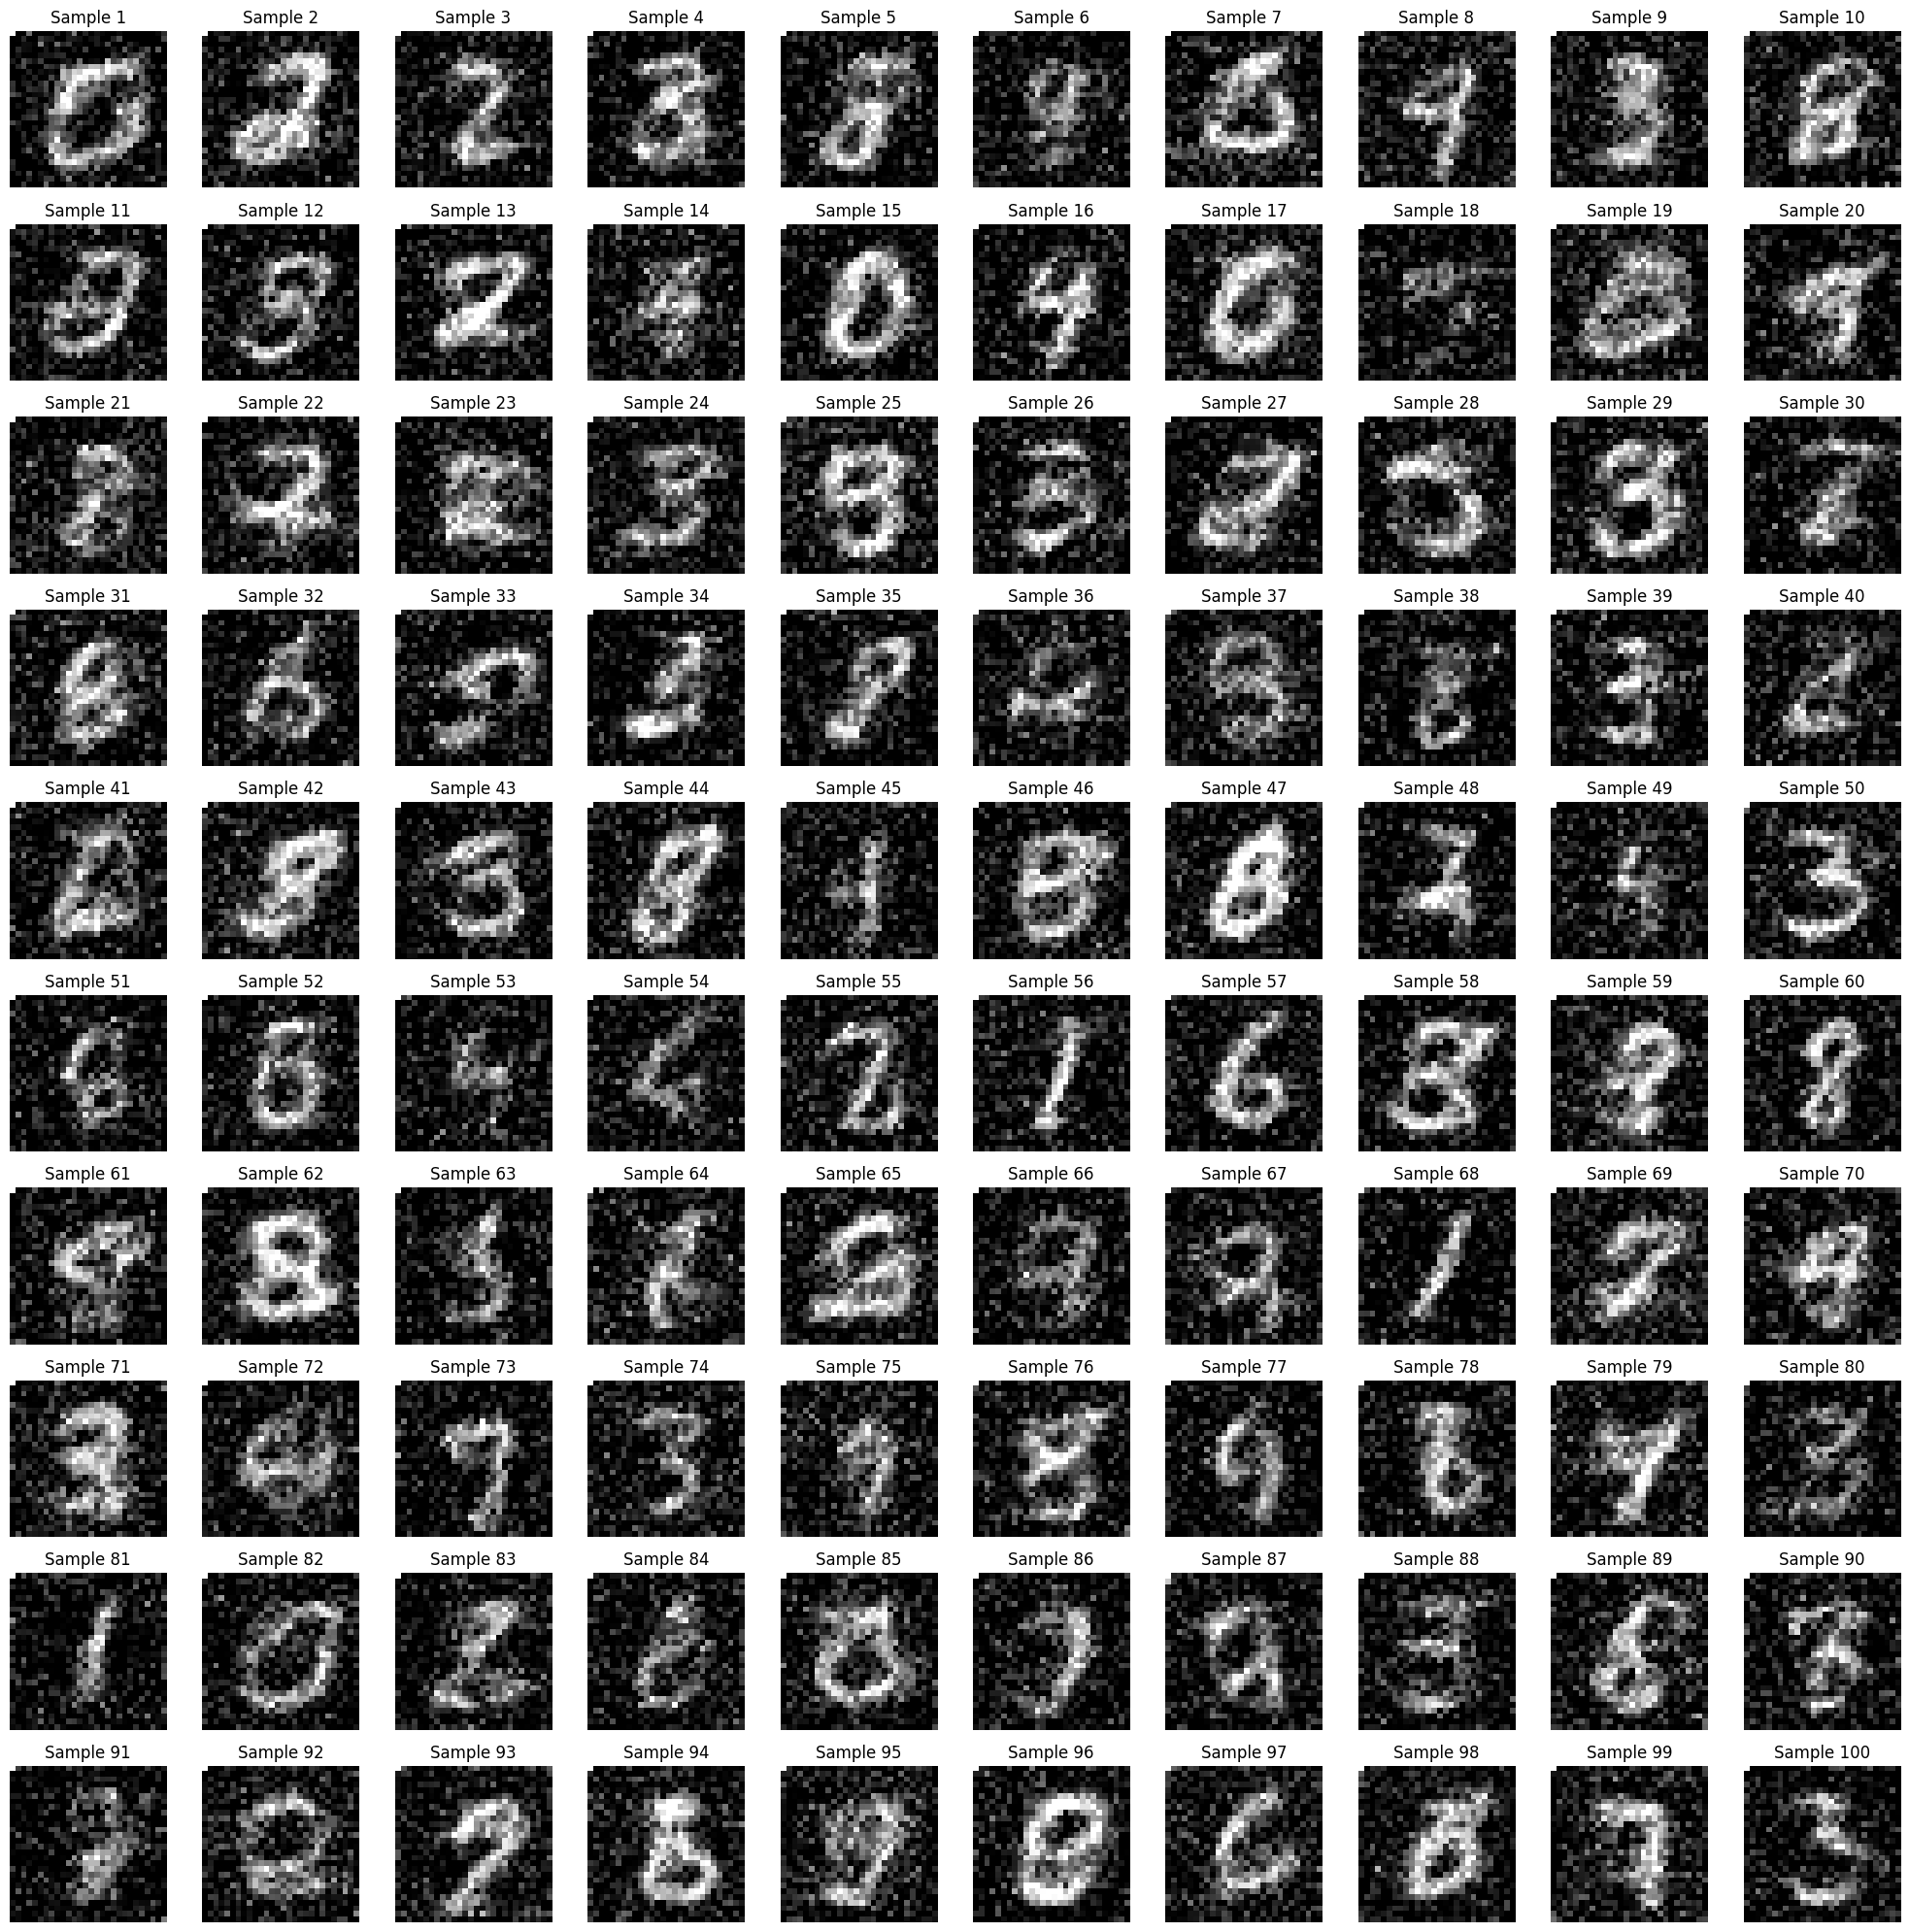

In [ ]:

sample_efficient_plot_multiply(model_generic.to(device), t_max=1, n_iter=1, n_samples=100)

It took: 0.10 seconds


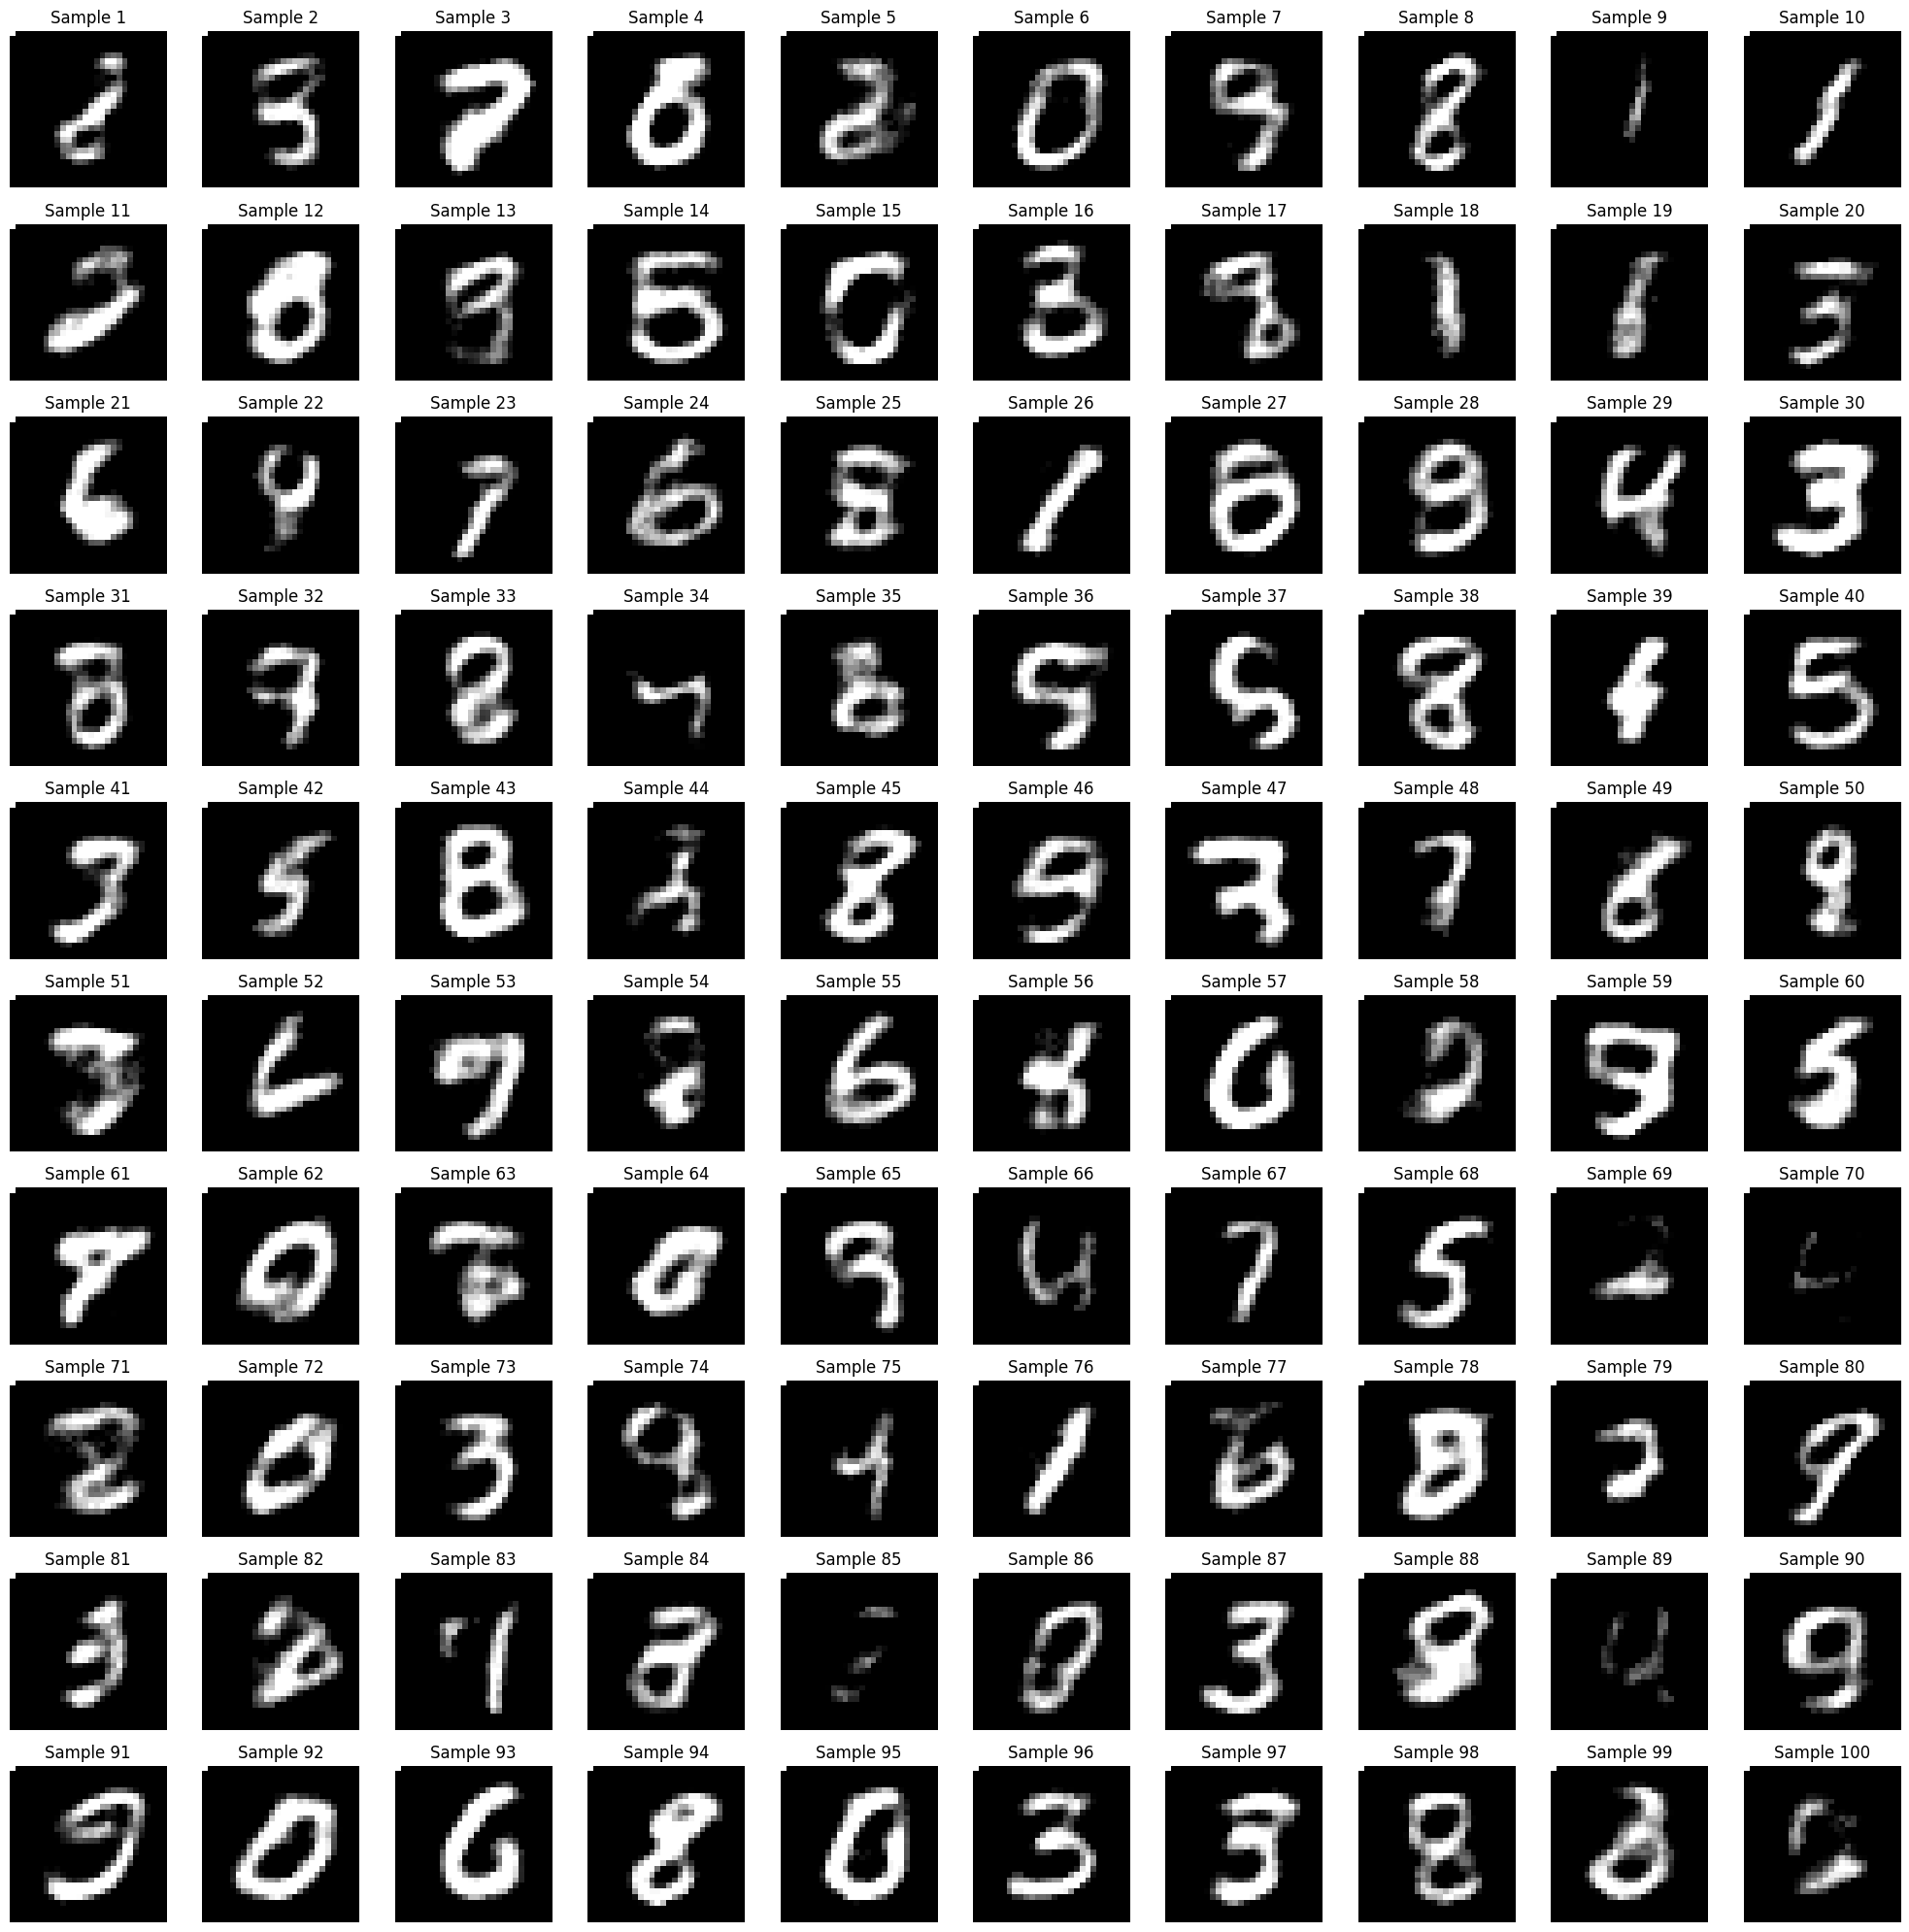

In [ ]:

sample_efficient_plot(model_generic.to(device), t_max=1, n_iter=2, n_samples=100)

In [ ]:
import numpy as np
import seaborn as sns

# Eigenvectors of Lie

In [ ]:
identity = torch.eye(1569).to("cuda")
lie_module = model_generic.to("cuda").koopman(identity).detach().cpu().numpy()
vals, vecs = np.linalg.eig(lie_module)

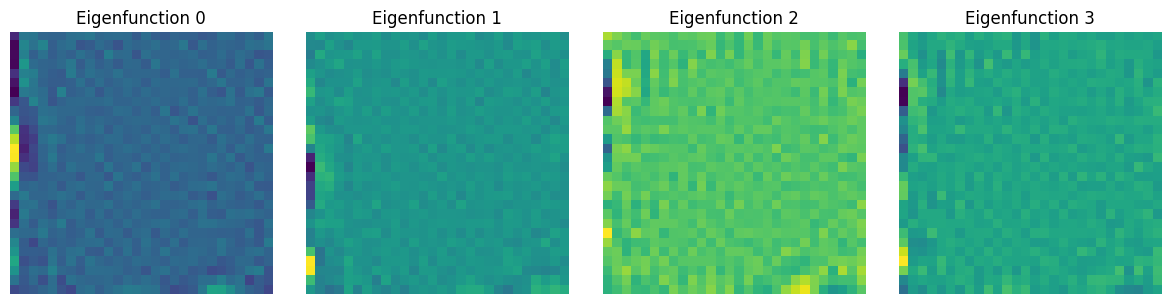

In [ ]:
#fifty lowest
import matplotlib.pyplot as plt
import numpy as np


indices = np.argsort(np.real(vals))[:4]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]

def plot_koopman_eigenfunctions(vecs, shape=(28, 28), cols=4, cmap='viridis', normalize=True):
    
    n = vecs.shape[1]
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axs = axs.flatten()

    for i in range(n):
        eigvec = np.real(vecs[1:1+28*28, i])#.real  # or .imag if you want imaginary part
        eigfunc = eigvec.reshape(shape)

        if normalize:
            eigfunc = (eigfunc - eigfunc.min()) / (eigfunc.max() - eigfunc.min() + 1e-8)

        axs[i].imshow(eigfunc, cmap=cmap)
        axs[i].set_title(f"Eigenfunction {i}")
        axs[i].axis("off")

    for i in range(n, len(axs)):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)


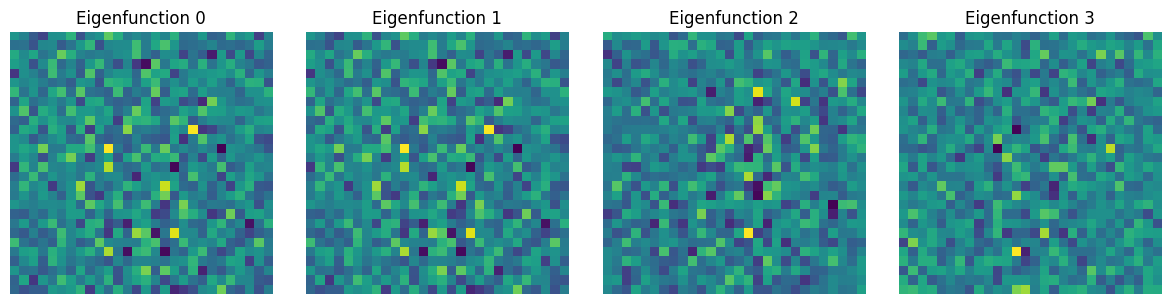

In [ ]:
indices = np.argsort(np.real(vals))[750:754]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]
plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)

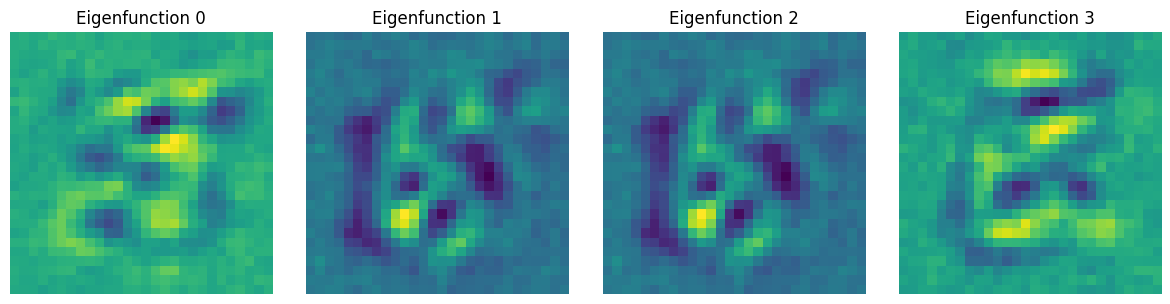

In [ ]:
indices = np.argsort(np.real(vals))[-4:]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]
plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)

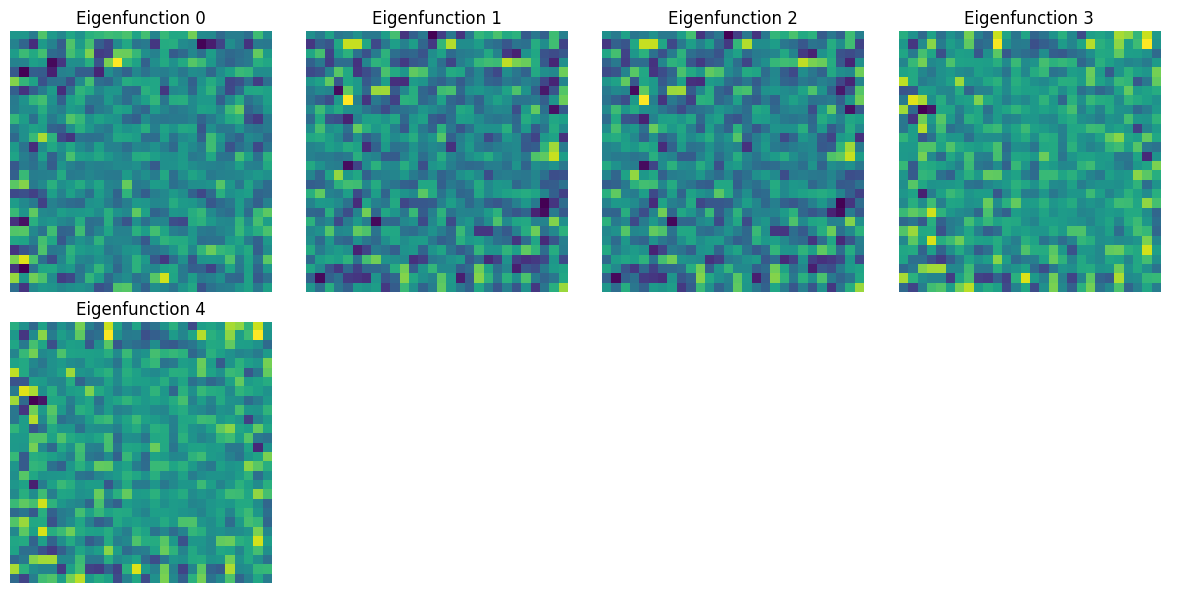

In [ ]:
#zero eigenvalues
threshold = 1e-1  # Adjust based on numerical precision
indices = np.where(np.abs(vals) < threshold)[0][:5]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]
plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)

In [ ]:
from time import time

# Analytical Projection with select Modes

In [ ]:
#project on a subset of decided indices
def sample_analytical_plot(model_generic, init,t_max=1, n_samples=1, start=0, end=1568):
    x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
    
    #Get
    identity = torch.eye(1569).to(device)
    lie_module = model_generic.to(device).koopman(identity)
    vals, P = torch.linalg.eig(lie_module)
    indices = torch.argsort(vals.real)
    indices = indices[start:end]
    
    
    
    
    P = P[:,indices]
    P_1 = torch.linalg.pinv(P) 
    vals = vals[indices]
    print(vals.shape)
    print(P_1.shape)
    
    
    
    # Preprocess initial conditions
    #x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28))
    x_0 = init
    t0 = torch.zeros((n_samples, 1), dtype=torch.float32).to(device)
    x_0 = torch.cat((t0, x_0), dim=1)

    #actual sampling time
    top = time()
    encoded = model_generic.autoencoder.encoder(x_0).to(torch.complex64)
    #print(encoded.shape)
    projected = (encoded@P)
    #print(projected.shape)
    evolved = (projected@torch.diag(torch.exp(vals*t_max)))
    #print(evolved.shape)
    decoded = model_generic.autoencoder.decoder((evolved@P_1).real).detach().cpu().numpy()
    

    # Koopman evolution in latent space
    torch.cuda.empty_cache()
    
    
    
    print(f'It took: {time()-top:.2f} seconds')

    # Plot all samples in a grid
    n_cols = math.ceil(math.sqrt(n_samples))
    n_rows = math.ceil(n_samples / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    axs = np.atleast_1d(axs).flatten()

    for i in range(n_samples):
        img = decoded[i][1:1 + 28 * 28].reshape((28, 28)).clip(-1, 1)
        axs[i].imshow(img, cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Sample {i + 1}")

    for j in range(n_samples, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()
    
    
    #return decoded.reshape((n_samples, 28, 28))

In [ ]:
n_samples = 1
x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28)).to("cuda")

torch.Size([1568])
torch.Size([1568, 1569])
It took: 0.01 seconds


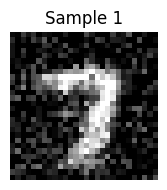

In [ ]:
sample_analytical_plot(model_generic,x_0, t_max=1, n_samples=1, start=0,end=1568)

torch.Size([100])
torch.Size([100, 1569])
It took: 0.01 seconds


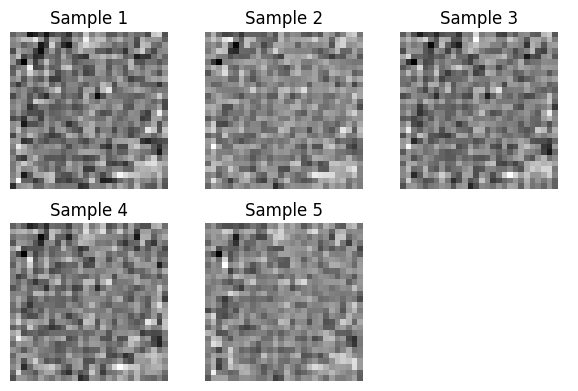

In [ ]:
sample_analytical_plot(model_generic, t_max=0.8, n_samples=5, start=1300,end=1400)

torch.Size([69])
torch.Size([69, 1569])
It took: 0.01 seconds


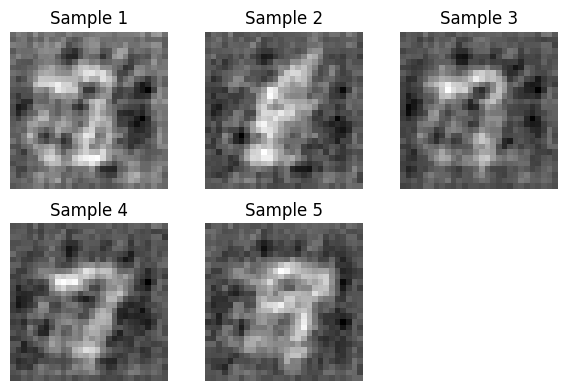

In [ ]:
sample_analytical_plot(model_generic, t_max=1, n_samples=5, start=1500,end=1569)

# T-SNE trajectories

In [ ]:
def analytical_trajectories(model_generic, traj, n_traj=1, start=0,end=50, device="cpu"):
    model_generic = model_generic.to(device)
    x_0 = traj[0][:n_traj].to(device)  # shape: (n_traj, 1, 28, 28)
    timespan = torch.linspace(0,1, 100).to(device)

    # Koopman operator and eigendecomposition
    L = model_generic.koopman.operator.to(device).to(torch.complex64)
    vals, P = torch.linalg.eig(L)
    indices = torch.argsort(np.real(vals))
    indices = indices[start:end]

    
       
    # Use only selected subset
    indices = torch.tensor(indices, dtype=torch.long, device=device)
    P_k = P[:, indices]
    vals_k = vals[indices]

    P_k_inv = torch.linalg.pinv(P_k)

    trajectories = []

    # Preprocess initial state
    x_0 = x_0.reshape((n_traj, 28 * 28))
    trajectories.append(x_0)

    for t in timespan[:-1]:
        t_tensor = torch.full((n_traj, 1), t, dtype=torch.float32).to(device)
        x = torch.cat((t_tensor, x_0), dim=1)

        encoded = model_generic.autoencoder.encoder(x).to(torch.complex64)

        # Koopman evolution using selected modes
        alpha = encoded @ P_k                      # project to selected Koopman subspace
        evolved = alpha @ torch.diag(torch.exp(vals_k * t))  # time evolution
        z_t = evolved @ P_k_inv                    # project back to latent space

        x = model_generic.autoencoder.decoder(z_t.real)
        x_0 = x[:, 1:]  # remove time channel

        trajectories.append(x_0)

    return torch.stack(trajectories, dim=0)  


# T-SNE trajectories of Koopy vs CFM

/tmp/ipykernel_2095049/45838364.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x800 with 0 Axes>

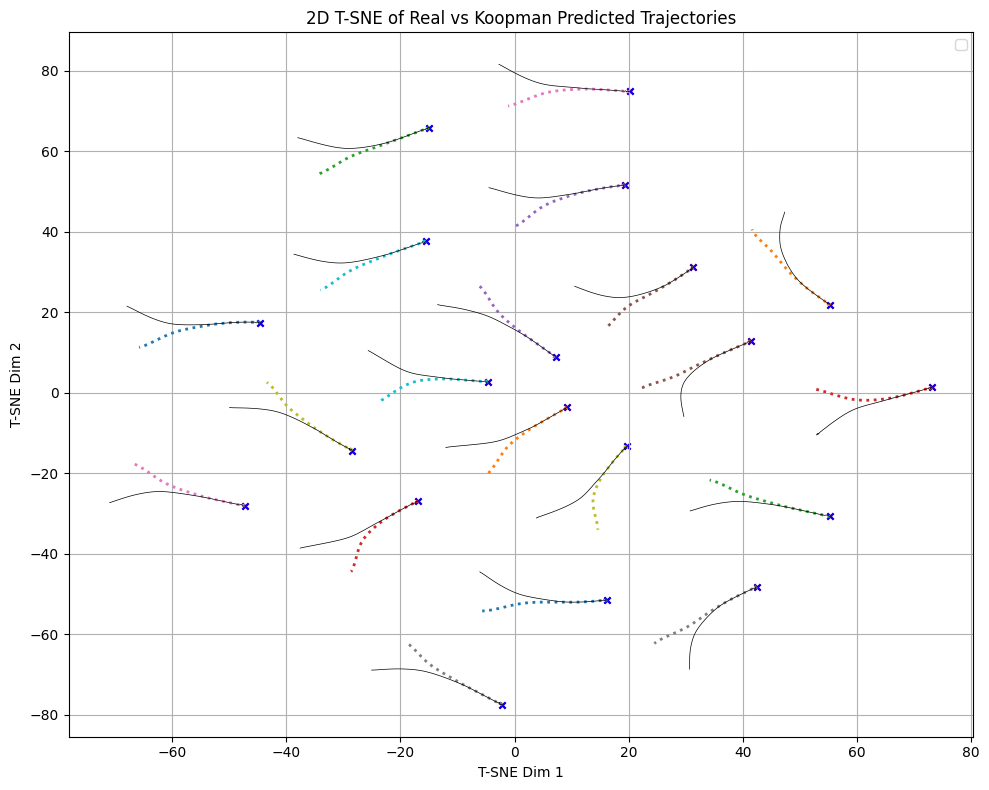

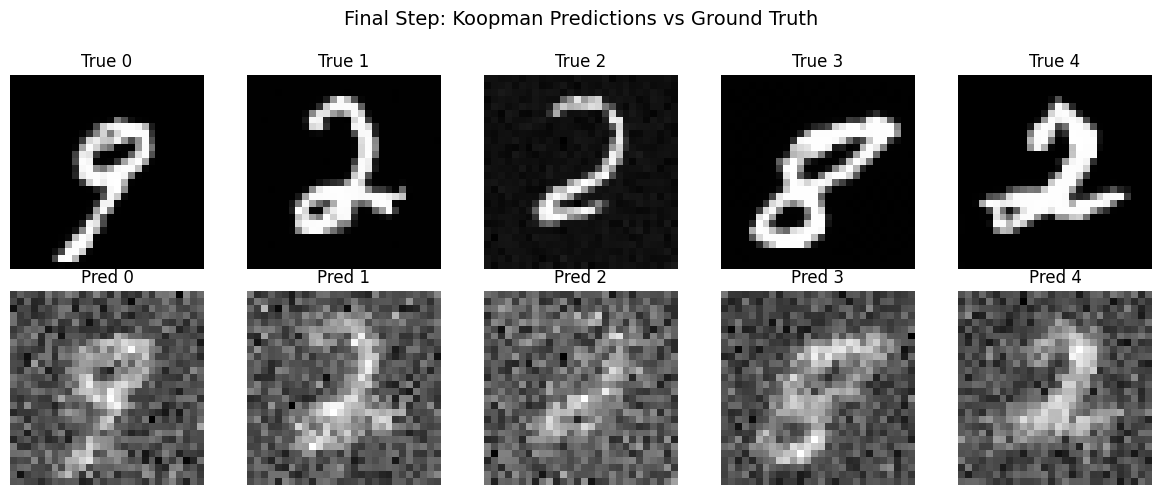

In [ ]:
def analytical_trajectories(model_generic , traj, n_traj=1, device="cpu"):
    model_generic = model_generic.to(device)
    x_0 = traj[0][:n_traj].to(device)  # Initial conditions
    #x_0 = torch.randn_like(x_0).to(device)
    timespan = torch.linspace(0,1,100).to(device)
    

    lie_module = model_generic.koopman.operator.to(device)
    delta_t = timespan[1]-timespan[0]
    koopman = torch.matrix_exp(lie_module*delta_t)
    
    trajectories = []
    
    
    # Preprocess initial conditions
    
    x_0 = x_0.reshape((n_traj, 28 * 28))
    trajectories.append(x_0)
    for t in timespan[:-1]:
        
        if t==0:
            t_tensor = torch.ones((n_traj, 1), dtype=torch.float32).to(device)*t
        else:
            t_tensor = x[:,0].reshape(-1,1)
        x = torch.cat((t_tensor, x_0), dim=1)
        encoded = model_generic.autoencoder.encoder(x)
        evolved = encoded@koopman
        x = model_generic.autoencoder.decoder(evolved)
        x_0 = x[:,1:]

        trajectories.append(x_0)   
    

    
    
    
    return torch.stack(trajectories, dim=0)

koopman_trajectories = analytical_trajectories(model_generic , traj=traj, n_traj=20)
koopman_trajectories.shape
traj_flattened = traj[:,:20,:,:].reshape(koopman_trajectories.shape)
traj_flattened.shape

from sklearn.manifold import TSNE

# Convert to NumPy
koopman_trajectories_np = koopman_trajectories.detach().numpy()  # (100, 20, 784)
koopman_samples = koopman_trajectories_np[-1,:,:].reshape(20,28,28)

traj_flattened_np = traj_flattened.detach().numpy()              # Possibly (100, 20, 784)
true_samples = traj_flattened_np[-1,:,:].reshape(20, 28, 28)

# Fix shape
traj_data = traj_flattened_np.reshape(-1, 784)        # Now (100, 784)

# Flatten koopman trajectories: (5, 100, 784) -> (500, 784)
koopman_data = koopman_trajectories_np.reshape(-1, 784)

# Combine for TSNE
combined = np.concatenate([traj_data, koopman_data], axis=0)

# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined)

# Split results back
real_tsne = tsne_results[:traj_data.shape[0]].reshape(100, 20, 2)
koopman_tsne = tsne_results[traj_data.shape[0]:].reshape(100, 20, 2)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for i in range(20):
    # Koopman predicted trajectory
    plt.plot(koopman_tsne[:, i, 0], koopman_tsne[:, i, 1], linestyle="dotted", linewidth=2, alpha=1)
    plt.scatter(koopman_tsne[0, i, 0], koopman_tsne[0, i, 1], color='red', marker='x', s=20)

    # Real trajectory
    plt.plot(real_tsne[:, i, 0], real_tsne[:, i, 1], color='black', linewidth=0.5)
    plt.scatter(real_tsne[0, i, 0], real_tsne[0, i, 1], color='blue', marker='x', s=20)

plt.title("2D T-SNE of Real vs Koopman Predicted Trajectories")
plt.xlabel("T-SNE Dim 1")
plt.ylabel("T-SNE Dim 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Koopman vs True samples at final time step
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Final Step: Koopman Predictions vs Ground Truth", fontsize=14)

# Top row: Ground truth
for i in range(5):
    axes[0, i].imshow(true_samples[i], cmap="gray")
    axes[0, i].set_title(f"True {i}")
    axes[0, i].axis("off")

# Bottom row: Koopman predictions
for i in range(5):
    axes[1, i].imshow(koopman_samples[i], cmap="gray")
    axes[1, i].set_title(f"Pred {i}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


   

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def run_koopman_tsne_plot(model_generic, traj, n_traj=20, device="cpu"):
    def analytical_trajectories(model_generic, traj, n_traj=1, device="cpu"):
        model_generic = model_generic.to(device)

        #initial conditions
        x_0 = traj[0][:n_traj].to(device)
        timespan = torch.linspace(0, 1, 100).to(device)

        lie_module = model_generic.koopman.operator.to(device)
        delta_t = timespan[1] - timespan[0]
        koopman = torch.matrix_exp(lie_module * delta_t)

        trajectories = []
        x_0 = x_0.reshape((n_traj, 28 * 28))
        trajectories.append(x_0)

        for t in timespan[:-1]:
            t_tensor = torch.full((n_traj, 1), t, dtype=torch.float32).to(device)
            x = torch.cat((t_tensor, x_0), dim=1)
            encoded = model_generic.autoencoder.encoder(x)
            evolved = encoded @ koopman
            x = model_generic.autoencoder.decoder(evolved)
            x_0 = x[:, 1:]
            trajectories.append(x_0)

        return torch.stack(trajectories, dim=0)  # (time, batch, 784)

    #Simulate Koopman Trajectories
    koopman_trajectories = analytical_trajectories(model_generic, traj, n_traj=n_traj, device=device)
    traj_flattened = traj[:koopman_trajectories.shape[0], :n_traj].reshape(koopman_trajectories.shape)

    #Prepare for t-SNE
    koop_np = koopman_trajectories.detach().cpu().numpy()
    traj_np = traj_flattened.detach().cpu().numpy()

    koop_samples = koop_np[-1].reshape(n_traj, 28, 28)
    true_samples = traj_np[-1].reshape(n_traj, 28, 28)

    traj_data = traj_np.reshape(-1, 784)
    koop_data = koop_np.reshape(-1, 784)

    combined = np.concatenate([traj_data, koop_data], axis=0)
    tsne_results = TSNE(n_components=2, random_state=42).fit_transform(combined)

    real_tsne = tsne_results[:traj_data.shape[0]].reshape(100, n_traj, 2)
    koop_tsne = tsne_results[traj_data.shape[0]:].reshape(100, n_traj, 2)

    #Plot t-SNE Trajectories
    plt.figure(figsize=(10, 8))
    for i in range(n_traj):
        plt.plot(koop_tsne[:, i, 0], koop_tsne[:, i, 1], linestyle="dotted", linewidth=2, alpha=1)
        plt.scatter(koop_tsne[0, i, 0], koop_tsne[0, i, 1], color='red', marker='x', s=20)
        plt.plot(real_tsne[:, i, 0], real_tsne[:, i, 1], color='black', linewidth=0.5)
        plt.scatter(real_tsne[0, i, 0], real_tsne[0, i, 1], color='blue', marker='x', s=20)

    plt.title("2D T-SNE of Real vs Koopman Predicted Trajectories")
    plt.xlabel("T-SNE Dim 1")
    plt.ylabel("T-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Final Step: Koopman vs Ground Truth ===
    fig, axes = plt.subplots(2, min(n_traj, 5), figsize=(12, 5))
    fig.suptitle("Final Step: Koopman Predictions vs Ground Truth", fontsize=14)

    for i in range(min(n_traj, 5)):
        axes[0, i].imshow(true_samples[i], cmap="gray")
        axes[0, i].set_title(f"True {i}")
        axes[0, i].axis("off")

        axes[1, i].imshow(koop_samples[i], cmap="gray")
        axes[1, i].set_title(f"Pred {i}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


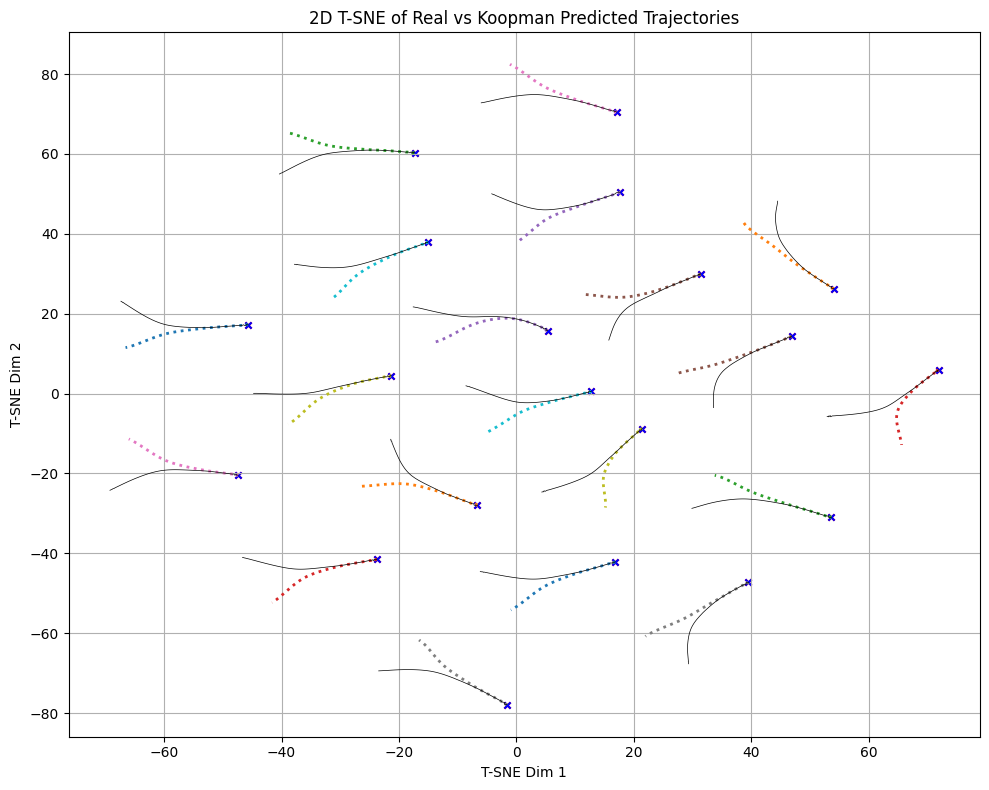

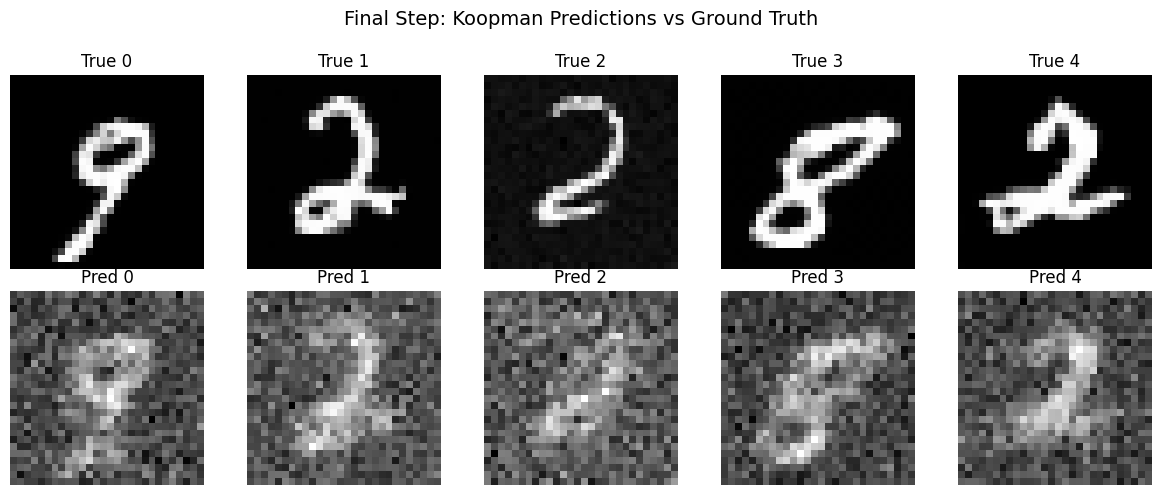

In [ ]:
run_koopman_tsne_plot(model_generic, traj, n_traj=20, device="cpu")


# Non-Linear measurements discerning? 

In [ ]:
# Model to classify the what trajectory leads to
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate model, optimizer, loss
classifier = SimpleCNN().to(device)
classifier.load_state_dict(torch.load("best_mnist_classifier.pt"))

<All keys matched successfully>

In [ ]:
#script to train it
classifier = SimpleCNN().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Optional validation loader
val_loader = test_loader

# Training loop
best_acc = 0.0
for epoch in range(1, 11):  # 10 epochs
    classifier.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(classifier(images), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} | Train Loss: {total_loss / len(train_loader):.4f}")

    # Evaluate on validation set
    classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total * 100
    print(f"Validation Accuracy: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(classifier.state_dict(), "best_mnist_classifier.pt")

In [ ]:
#Get the labels for a trajectory
def trajectory_labels(traj, classifier, batch_size, device="cpu"):
    generated = traj[-1,:,:,:,:]
    labels = []
    classifier = classifier.to(device)
    for i in range(0,traj.shape[1],batch_size):
        start = i
        end = start+batch_size
        batch = generated[start:end].to(device)
        outputs = classifier(batch)
        preds = outputs.argmax(1)
        labels.append(preds)
    return torch.cat(labels)

labels = trajectory_labels(traj, classifier, 128)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.manifold import TSNE
import torch
import numpy as np

def tsne_koopman_subset_modes(model_generic, traj, labels, n_samples=1000, time_step=0, 
                              modes_to_use=None, device="cpu"):
    model_generic = model_generic.to(device)
    
    # Time setup
    time = torch.linspace(0, 1, 100).to(device)
    delta_t = time[1] - time[0]
    t = time_step * delta_t
    
    # Prepare input
    x_0 = traj[time_step][:n_samples].reshape(n_samples, -1).to(device)
    t_0 = torch.full((n_samples, 1), t, dtype=torch.float32).to(device)
    x_t = torch.cat((t_0, x_0), dim=1)

    # Encode to latent space
    encoded = model_generic.autoencoder.encoder(x_t).to(torch.complex64)  # (n_samples, D)

    # Koopman eigendecomposition
    koopman_op = model_generic.koopman.operator.to(device).to(torch.complex64)
    vals, P = torch.linalg.eig(koopman_op)  # P: (D, D)
    order = torch.argsort(np.real(vals))
    vals, P = vals[order], P[:,order]

    # Select Koopman modes (columns of P)
    if modes_to_use is None:
        modes_to_use = torch.arange(P.shape[1])  # use all modes if none selected
    P_subset = P[:, modes_to_use]  # (D, len(modes_to_use))

    # Project onto selected Koopman modes
    alpha = encoded @ P_subset  # (n_samples, len(modes_to_use))

    # t-SNE on projected Koopman coordinates
    alpha_real = alpha.real.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(alpha_real)

    # Labels
    labels_np = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]

    # Plot using tab10
    cmap = get_cmap('tab10')
    plt.figure(figsize=(8, 6))
    for i in range(10):
        idx = labels_np == i
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1],
                    c=[cmap(i)], label=f"Class {i}", s=6, alpha=0.8)
    
    plt.legend(markerscale=2, fontsize=9, title="Classes")
    plt.title("t-SNE on Subset of Koopman Modes")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2095049/2424208637.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


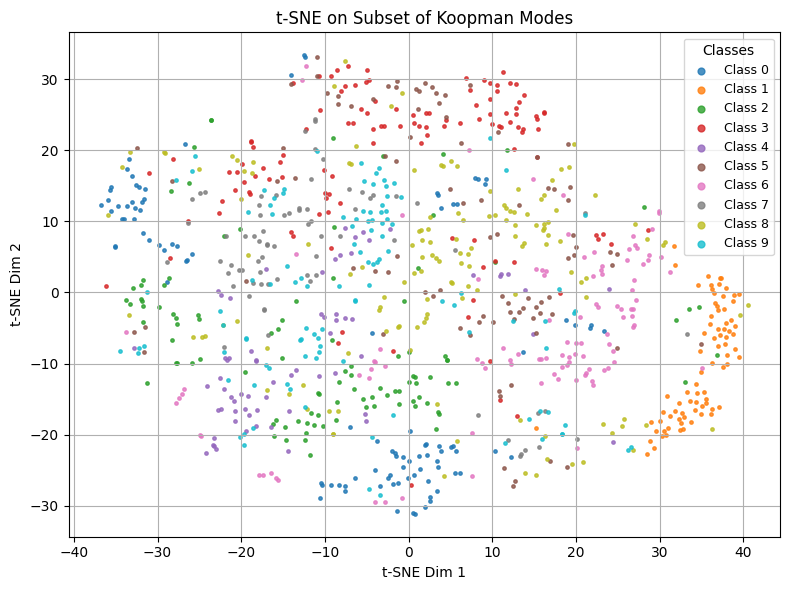

In [ ]:
tsne_koopman_subset_modes(model_generic, traj, labels, n_samples=1000, time_step=99, 
                              modes_to_use=[i for i in range(1500,1568)], device="cpu")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def k_nn_accuracy_over_time(model, traj, labels, modes_to_use, n_samples, device="cpu"):
    accuracies = []
    time_steps = np.linspace(0, 99, 10, dtype=int)  # 10 step increments from t=0 to t=1
    time = torch.linspace(0, 1, 100).to(device)
    delta_t = time[1] - time[0]
    model = model.to(device)

    for time_step in time_steps:
        t = time_step * delta_t

        # Prepare input
        x_0 = traj[time_step][:n_samples].reshape(n_samples, -1).to(device)
        t_0 = torch.full((n_samples, 1), t, dtype=torch.float32).to(device)
        x_t = torch.cat((t_0, x_0), dim=1)

        # Encode to latent space
        encoded = model.autoencoder.encoder(x_t).to(torch.complex64)  # (n_samples, D)

        # Koopman eigendecomposition
        koopman_op = model.koopman.operator.to(device).to(torch.complex64)
        vals, P = torch.linalg.eig(koopman_op)
        order = torch.argsort(torch.real(vals))
        vals, P = vals[order], P[:, order]

        # Select Koopman modes
        if modes_to_use is None:
            modes_to_use = torch.arange(P.shape[1])
        P_subset = P[:, modes_to_use]

        # Project onto selected Koopman modes
        alpha = encoded @ P_subset
        alpha_real = alpha.real.detach().cpu().numpy()

        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(alpha_real)

        # K-NN classification
        labels_np = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]
        X_train, X_test, y_train, y_test = train_test_split(tsne_result, labels_np, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plot
    times = time_steps * delta_t.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(times, accuracies, marker='o')
    plt.title("K-NN Classification Accuracy over Time")
    plt.xlabel("Time t")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return accuracies


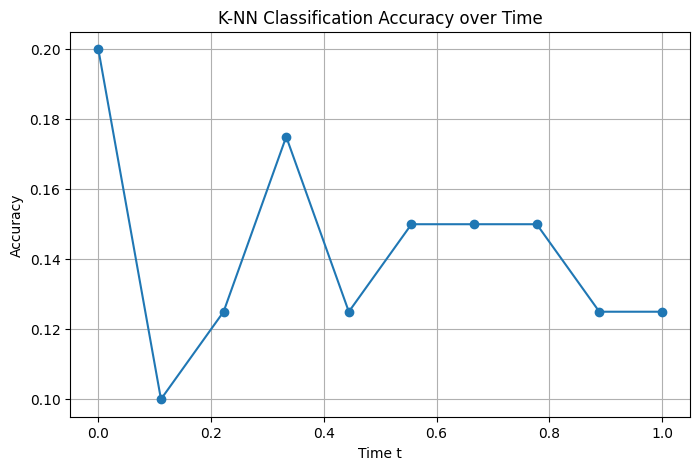

In [ ]:
#for fast decay 0-200 modes 
accuracies_decay = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(50)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

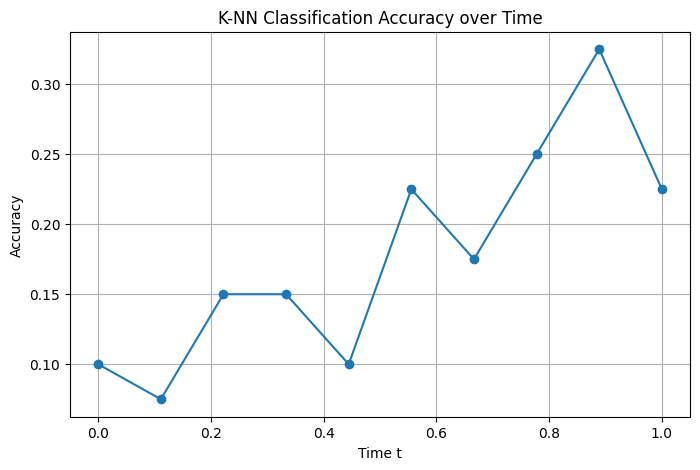

In [ ]:
#for middle modes
accuracies_mid = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(600,800)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

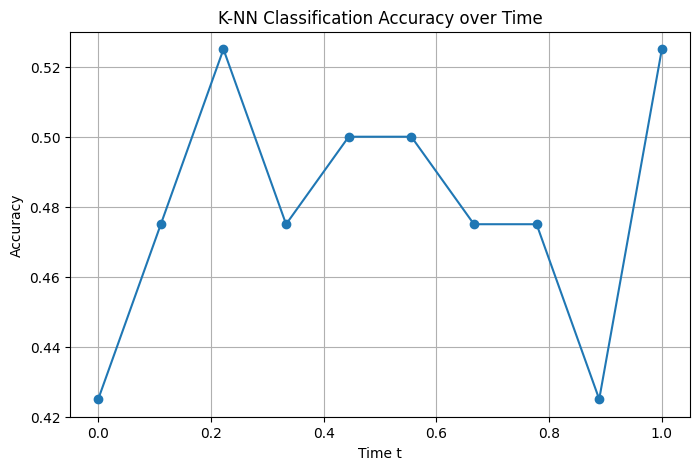

In [ ]:
#for fast growth
accuracies_growth = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(1500,1569)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

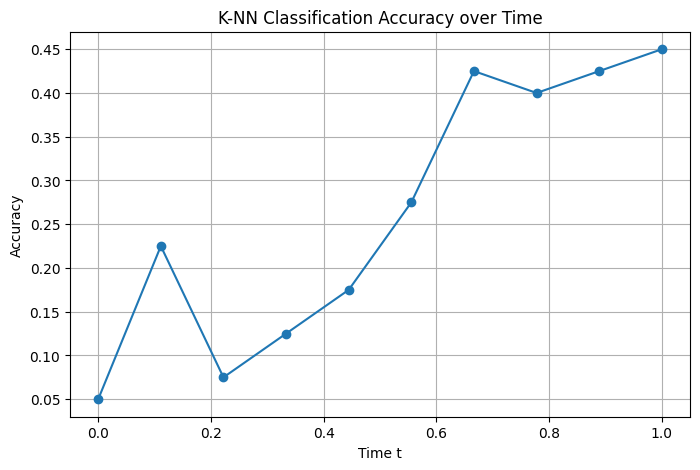

In [ ]:
#all modes
accuracies = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(0,1568)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

In [ ]:
len(accuracies_decay)

10

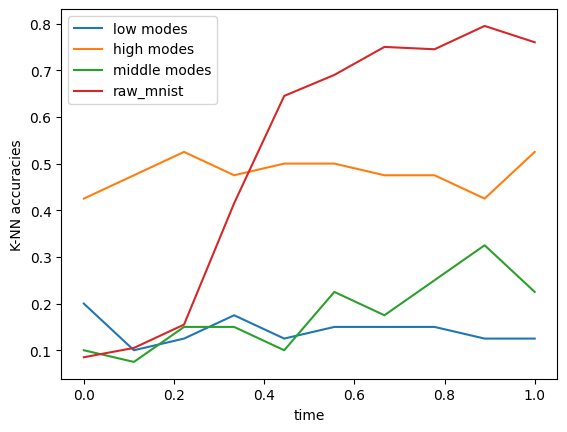

In [ ]:
t = np.linspace(0,1,10)
plt.plot(t, accuracies_decay, label="low modes")
plt.plot(t, accuracies_growth, label="high modes")
plt.plot(t, accuracies_mid, label="middle modes")
plt.plot(t, accuracies, label="raw_mnist")
plt.xlabel("time")
plt.ylabel("K-NN accuracies")
plt.legend()


In [ ]:
#for fast decay 400-600 modes
accuracies = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(400,600)],
    n_samples=200,
    device="cpu"  
)

/tmp/ipykernel_2095049/2424208637.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


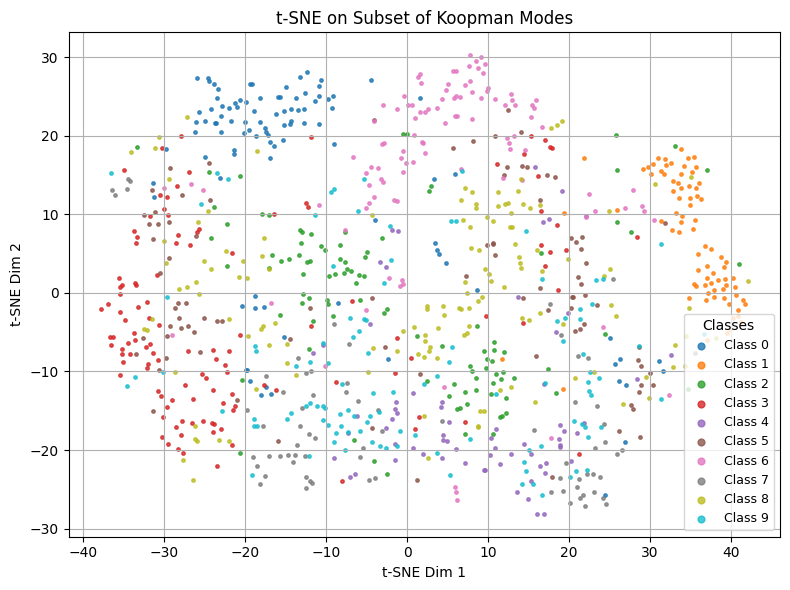

In [ ]:
tsne_koopman_subset_modes(model_generic, traj, labels, n_samples=1000,modes_to_use=[i for i in range(1500,1568)], time_step=0)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_accuracy_raw_mnist(traj, labels, n_samples=1000, device="cpu"):
    accuracies = []
    time_steps = np.linspace(0, 99, 10, dtype=int)  # 10 time steps
    time = torch.linspace(0, 1, 100).to(device)
    delta_t = time[1] - time[0]

    for time_step in time_steps:
        # Get raw MNIST data at this time step
        x = traj[time_step][:n_samples].reshape(n_samples, -1).cpu().numpy()
        y = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]

        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(x)

        # K-NN classification
        X_train, X_test, y_train, y_test = train_test_split(tsne_result, y, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plot
    times = time_steps * delta_t.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(times, accuracies, marker='o')
    plt.title("K-NN Classification Accuracy on Raw MNIST (t-SNE) Over Time")
    plt.xlabel("Time t")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracies


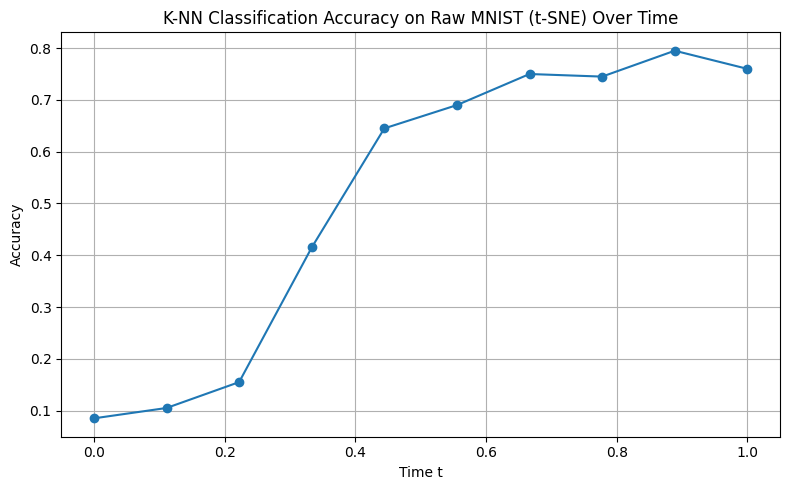

In [ ]:
accuracies = knn_accuracy_raw_mnist(traj, labels, n_samples=1000, device="cuda")


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def tsne_raw_data(model_generic, n_samples=1000,time_step=0, device="cuda"):
    
    


    # t-SNE on Koopman coordinates
    alpha_real = traj[time_step][:n_samples].reshape(n_samples,-1)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(alpha_real)

    # Labels
    labels_np = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]

    # Use tab10 colormap
    cmap = get_cmap('tab10')

    plt.figure(figsize=(8, 6))
    for i in range(10):
        idx = labels_np == i
        plt.scatter(
            tsne_result[idx, 0], tsne_result[idx, 1],
            c=[cmap(i)], label=f"Class {i}", s=6, alpha=0.8
        )

    plt.legend(markerscale=2, fontsize=9, title="Classes")
    plt.title("t-SNE of Encoded Inputs in Koopman Eigenbasis")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2095049/3177795909.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


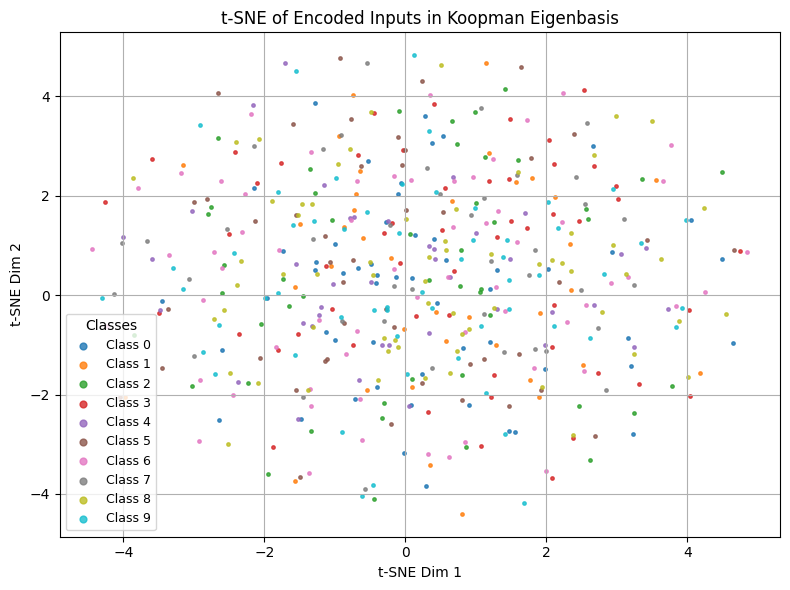

In [ ]:
tsne_raw_data(model_generic, n_samples=500,time_step=0, device="cpu")

# Do the n most active modes seperate the classes:

In [ ]:
device = "cpu"

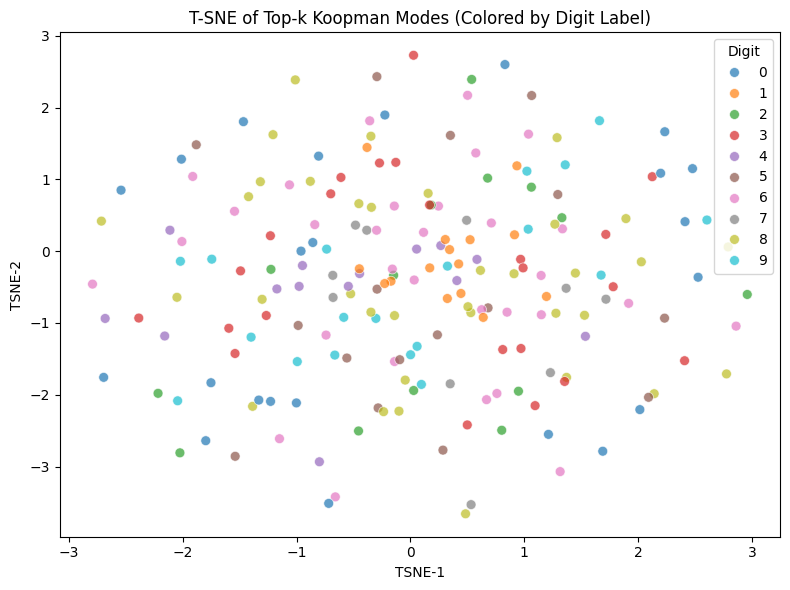

In [ ]:
model_generic = model_generic.to(device)
time_step = 99
n_samples = 200   
# Time setup
time = torch.linspace(0, 1, 100).to(device)
delta_t = time[1] - time[0]
t = time_step * delta_t
    
# Prepare input
x_0 = traj[time_step][:n_samples].reshape(n_samples, -1).to(device)
t_0 = torch.full((n_samples, 1), t, dtype=torch.float32).to(device)
x_t = torch.cat((t_0, x_0), dim=1)

# Encode to latent space
encoded = model_generic.autoencoder.encoder(x_t).to(torch.complex64)  # (n_samples, D)
koopman_op = model_generic.koopman.operator.to(device).to(torch.complex64)
vals, P = torch.linalg.eig(koopman_op)
coefficients = encoded@koopman_op 
magnitudes = torch.abs(coefficients)  # shape (4, 10), real-valued
k = 200
topk_values, topk_indices = torch.topk(magnitudes, k=k, dim=1)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns  # for nicer coloring
import numpy as np


topk_indices_np = topk_indices.cpu().numpy()  

labels_np = labels.cpu().numpy()[:n_samples]             

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto')



tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(topk_indices_np)


plt.figure(figsize=(8, 6))
palette = sns.color_palette("tab10", 10)  
sns.scatterplot(
    x=tsne_result[:, 0], y=tsne_result[:, 1],
    hue=labels_np,
    palette=palette,
    legend='full',
    s=50,
    alpha=0.7
)
plt.title("T-SNE of Top-k Koopman Modes (Colored by Digit Label)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Digit")
plt.tight_layout()
plt.show()


In [ ]:
topk_indices_np

array([[3.1415927, 3.1415927, 3.1415927, ..., 3.1415927, 3.1415927,
        3.1415927],
       [3.1415927, 3.1415927, 3.1415927, ..., 3.1415927, 3.1415927,
        3.1415927],
       [3.1415927, 3.1415927, 3.1415927, ..., 3.1415927, 3.1415927,
        3.1415927],
       ...,
       [3.1415927, 3.1415927, 3.1415927, ..., 3.1415927, 3.1415927,
        3.1415927],
       [3.1415927, 3.1415927, 3.1415927, ..., 3.1415927, 3.1415927,
        3.1415927],
       [3.1415927, 3.1415927, 3.1415927, ..., 3.1415927, 3.1415927,
        3.1415927]], shape=(200, 50), dtype=float32)

# Operator + Spectrum

<Axes: >

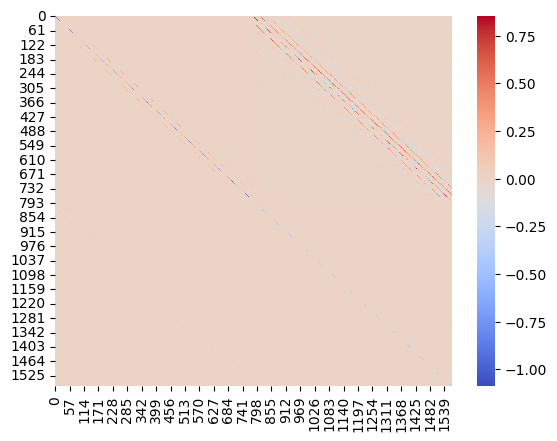

In [ ]:
operator = model_generic.koopman.operator.detach().cpu().numpy().T
sns.heatmap(operator, cmap = "coolwarm")

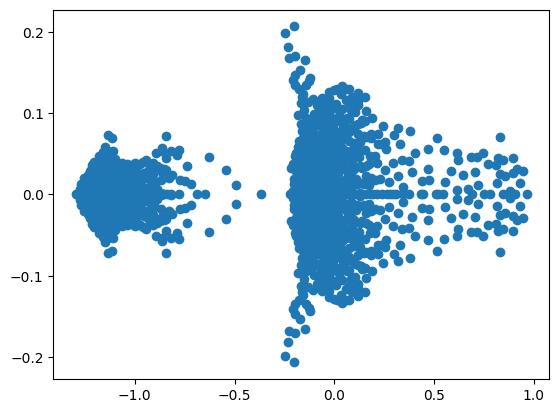

In [ ]:
vals, vecs = np.linalg.eig(operator)
plt.scatter(np.real(vals), np.imag(vals))